# Prerequisites

In [1]:
import numpy as np
import pandas as pd
from tm import StockDataProvider
from tm.trading_rules import SimpleMovingAverage, ExponentialMovingAverage, STO, MACD, RSI, ROC, BollingerBaender
from tm.optimizers import GeneticOptimizer, StrategyPerformanceEvaluator, map_chromosome_to_trading_rule_parameters, filter_for_active_rules, calculate_absolute_buy_and_hold_returns
from tm.backtesting import GeometricBrownianMotion, MonteCarloCrossValidation
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

Define the trading rule basis for the strategy.

In [2]:
trading_rules = [SimpleMovingAverage, ExponentialMovingAverage, STO, MACD, RSI, ROC, BollingerBaender]

Define a function which finds the best strategy by running the genetic algorithm and applying backtesting.

In [3]:
# Returns best strategy as bitvector
def find_best_strategy(ticker_name, start, end, ngen=None):
    # Retrieve stock data
    data = StockDataProvider(ticker_name, start=start, end=end)
    
    # Define function to find best strategy for a given number of generation
    def _find_best_strategy(ngen: int) -> MonteCarloCrossValidation:
        optimizer = GeneticOptimizer(data, trading_rules, random_seed=42)
        print('Running genetic algorithm ...')
        hof = optimizer.run(pop_size=1000, ngen=ngen, hof_size=100, mutpb=0.3, cxpb=0.6)
        print('Net profit of buy and hold:', calculate_absolute_buy_and_hold_returns(data))
        gbm = GeometricBrownianMotion(data)
        crossvalidator = MonteCarloCrossValidation(hof, gbm, trading_rules)
        print('Running backtesting ...')
        crossvalidator.run(num_iterations=100, time_steps=252)
        return crossvalidator
    
    # Run grid search to find best number of generations
    if ngen is None:
        print('Trying to figure out optimal number of generations using grid search ...')
        best_ngen, best_cv_score, best_individual = 0, float('-inf'), None
        for ngen in range(1, 21):
            print(f'Iteration {ngen} of 20 with best cv score:', best_cv_score)
            res: MonteCarloCrossValidation = _find_best_strategy(ngen)
            if res.max_mean_net_profit > best_cv_score:
                best_ngen, best_cv_score, best_individual = ngen, res.max_mean_net_profit, res.best_individual
            print('--------------------')
        print(f'Result of grid search: ngen={best_ngen} with score {best_cv_score}')
        return best_individual
    # or take given number of generations
    else:
        res: MonteCarloCrossValidation = _find_best_strategy(ngen)
        return res.best_individual

Define a function which prints the results for the testing period.

In [4]:
def print_test_results(individual, ticker_name, start, end):
    real_data = StockDataProvider(ticker_name, start=start, end=end)
    rule_instances = list(map(lambda Rule, params: Rule(real_data, *params), trading_rules, map_chromosome_to_trading_rule_parameters(individual, trading_rules)))
    active_rule_instances = filter_for_active_rules(individual, rule_instances)
    evaluator = StrategyPerformanceEvaluator(active_rule_instances)
    net_profit, _ = evaluator.calculate_net_profit()
    net_profit_bh = calculate_absolute_buy_and_hold_returns(real_data)
    percentage_profit = net_profit / real_data.history['Close'].iloc[0] * 100
    percentage_profit_bh = net_profit_bh / real_data.history['Close'].iloc[0] * 100
    print('Active rules:', list(map(lambda rule: rule.__class__.__name__, active_rule_instances)))
    print('Active rules\' parameters:', list(map(lambda param: param[1], filter(lambda param: trading_rules[param[0]] in map(lambda rule: rule.__class__, active_rule_instances), enumerate(map_chromosome_to_trading_rule_parameters(individual, trading_rules))))))
    print('Net profit of strategy: {:f}'.format(net_profit))
    print('Net profit of buy and hold: {:f}'.format(net_profit_bh))
    print('Percentage profit of strategy: {:f}%'.format(percentage_profit))
    print('Percentage profit of buy and hold: {:f}%'.format(percentage_profit_bh))
    print('Number of buy signals:', len(evaluator.buy_signals[evaluator.buy_signals == True]))
    print('Number of sell signals:', len(evaluator.sell_signals[evaluator.sell_signals == True]))
    del real_data
    return evaluator, percentage_profit, percentage_profit_bh

Define a function which can plot a strategy.

In [5]:
def plot_strategy(evaluator, ticker_name, start, end):
    data = StockDataProvider(ticker_name, start=start, end=end)
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    ax.plot(data.history['Close'], label='Stock prices')

    if len(evaluator.buy_signals[evaluator.buy_signals == True]) > 0:
        buy_points = pd.Series(data=map(lambda index, price: price if evaluator.buy_signals.loc[index] == True else np.nan, data.history['Close'].index, data.history['Close']),
                               index=data.history['Close'].index)
        ax.scatter(x=buy_points.index, y=buy_points, color='green', marker='^', label='Buy signal')
    
    if len(evaluator.sell_signals[evaluator.sell_signals == True]) > 0:
        sell_points = pd.Series(data=map(lambda index, price: price if evaluator.sell_signals.loc[index] == True else np.nan, data.history['Close'].index, data.history['Close']),
                               index=data.history['Close'].index)
        ax.scatter(x=sell_points.index, y=sell_points, color='red', marker='v', label='Sell signal')

    ax.set_xlabel('Date')
    ax.set_ylabel('Stock price')
    ax.legend()
    fig.tight_layout()
    del data

# Experiments

In [6]:
results = {'EXS1.DE': [],
           'ADS.DE': [],
           'ALV.DE': [],
           'BAS.DE': [],
           'DBK.DE': [],
           'DTE.DE': [],
           'SAP.DE': [],
           'DJI': [],
           'CSCO': [],
           'DD': [],
           'JPM': [],
           'MSFT': [],
           'NKE': [],
           'UNH': []}

## DAX

In [7]:
%%time
best_individual = find_best_strategy(ticker_name='EXS1.DE', start='2016-01-01', end='2018-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 10 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-119.753	12.8925	-31.2467	19.6128
1  	731   	-118.792	19.0007	-17.5087	14.8889
Net profit of buy and hold: 1.519725000000013
Running backtesting ...
Best individual: [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Best average net profit: 0.15642050648664135
--------------------
Iteration 2 of 10 with best cv score: 0.15642050648664135
Running genetic algorithm ...


/Users/phipag/miniconda3/envs/trading_machine/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/phipag/miniconda3/envs/trading_machine/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	min     	max    	mean    	std    
0  	1000  	-119.753	12.8925	-31.2467	19.6128
1  	731   	-118.792	19.0007	-17.5087	14.8889
2  	693   	-113.777	21.9267	-8.36503	12.8262
Net profit of buy and hold: 1.519725000000013
Running backtesting ...
Best individual: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]
Best average net profit: 0.7438708553450225
--------------------
Iteration 3 of 10 with best cv score: 0.7438708553450225
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-119.753	12.8925	-31.2467	19.6128
1  	731   	-118.792	19.0007	-17.5087	14.8889
2  	693   	-113.777	21.9267	-8.36503	12.8262
3  	732   	-110.882	37.1837	-2.51751	11.9688
Net profit of buy and hold: 1.519725000000013
Running backtesting .

4  	728   	-112.792	37.1837	2.11912 	10.215 
5  	736   	-112.082	37.1837	4.595   	12.573 
6  	732   	-112.802	37.1837	7.38436 	13.3648
7  	768   	-110.882	37.1837	10.1999 	13.5792
8  	718   	-61.4806	37.1837	12.7926 	11.8978
9  	701   	-55.7693	37.1837	15.0333 	11.6396
10 	732   	-112.692	37.1837	15.312  	14.127 
11 	724   	-56.5789	38.62  	17.692  	13.3757
Net profit of buy and hold: 1.519725000000013
Running backtesting ...
Best individual: [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Best average net profit: 4.301553101023324
--------------------
Iteration 12 of 10 with best cv score: 4.301553101023324
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-119.753	12.8925	-31.2467	19.6128
1  	731   	-118.792	19.

gen	nevals	min     	max    	mean    	std    
0  	1000  	-119.753	12.8925	-31.2467	19.6128
1  	731   	-118.792	19.0007	-17.5087	14.8889
2  	693   	-113.777	21.9267	-8.36503	12.8262
3  	732   	-110.882	37.1837	-2.51751	11.9688
4  	728   	-112.792	37.1837	2.11912 	10.215 
5  	736   	-112.082	37.1837	4.595   	12.573 
6  	732   	-112.802	37.1837	7.38436 	13.3648
7  	768   	-110.882	37.1837	10.1999 	13.5792
8  	718   	-61.4806	37.1837	12.7926 	11.8978
9  	701   	-55.7693	37.1837	15.0333 	11.6396
10 	732   	-112.692	37.1837	15.312  	14.127 
11 	724   	-56.5789	38.62  	17.692  	13.3757
12 	702   	-65.44  	43.6126	20.2329 	13.0692
13 	697   	-112.792	43.6126	20.9415 	15.9678
14 	728   	-112.792	43.6126	21.8165 	16.8791
15 	722   	-112.792	43.6126	23.9646 	16.6183
16 	691   	-112.082	43.6126	28.0391 	15.4063
17 	734   	-112.792	44.0914	29.4826 	16.1635
18 	685   	-61.7021	44.0914	30.1856 	15.9019
Net profit of buy and hold: 1.519725000000013
Running backtesting ...
Best individual: [0, 1, 1, 1, 

In [8]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='EXS1.DE', start='2019-01-01', end='2019-12-31')
results['EXS1.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[33, 49, 57], [31, 7]]
Net profit of strategy: 10.455300
Net profit of buy and hold: 21.888200
Percentage profit of strategy: 11.469175%
Percentage profit of buy and hold: 24.010750%
Number of buy signals: 3
Number of sell signals: 3


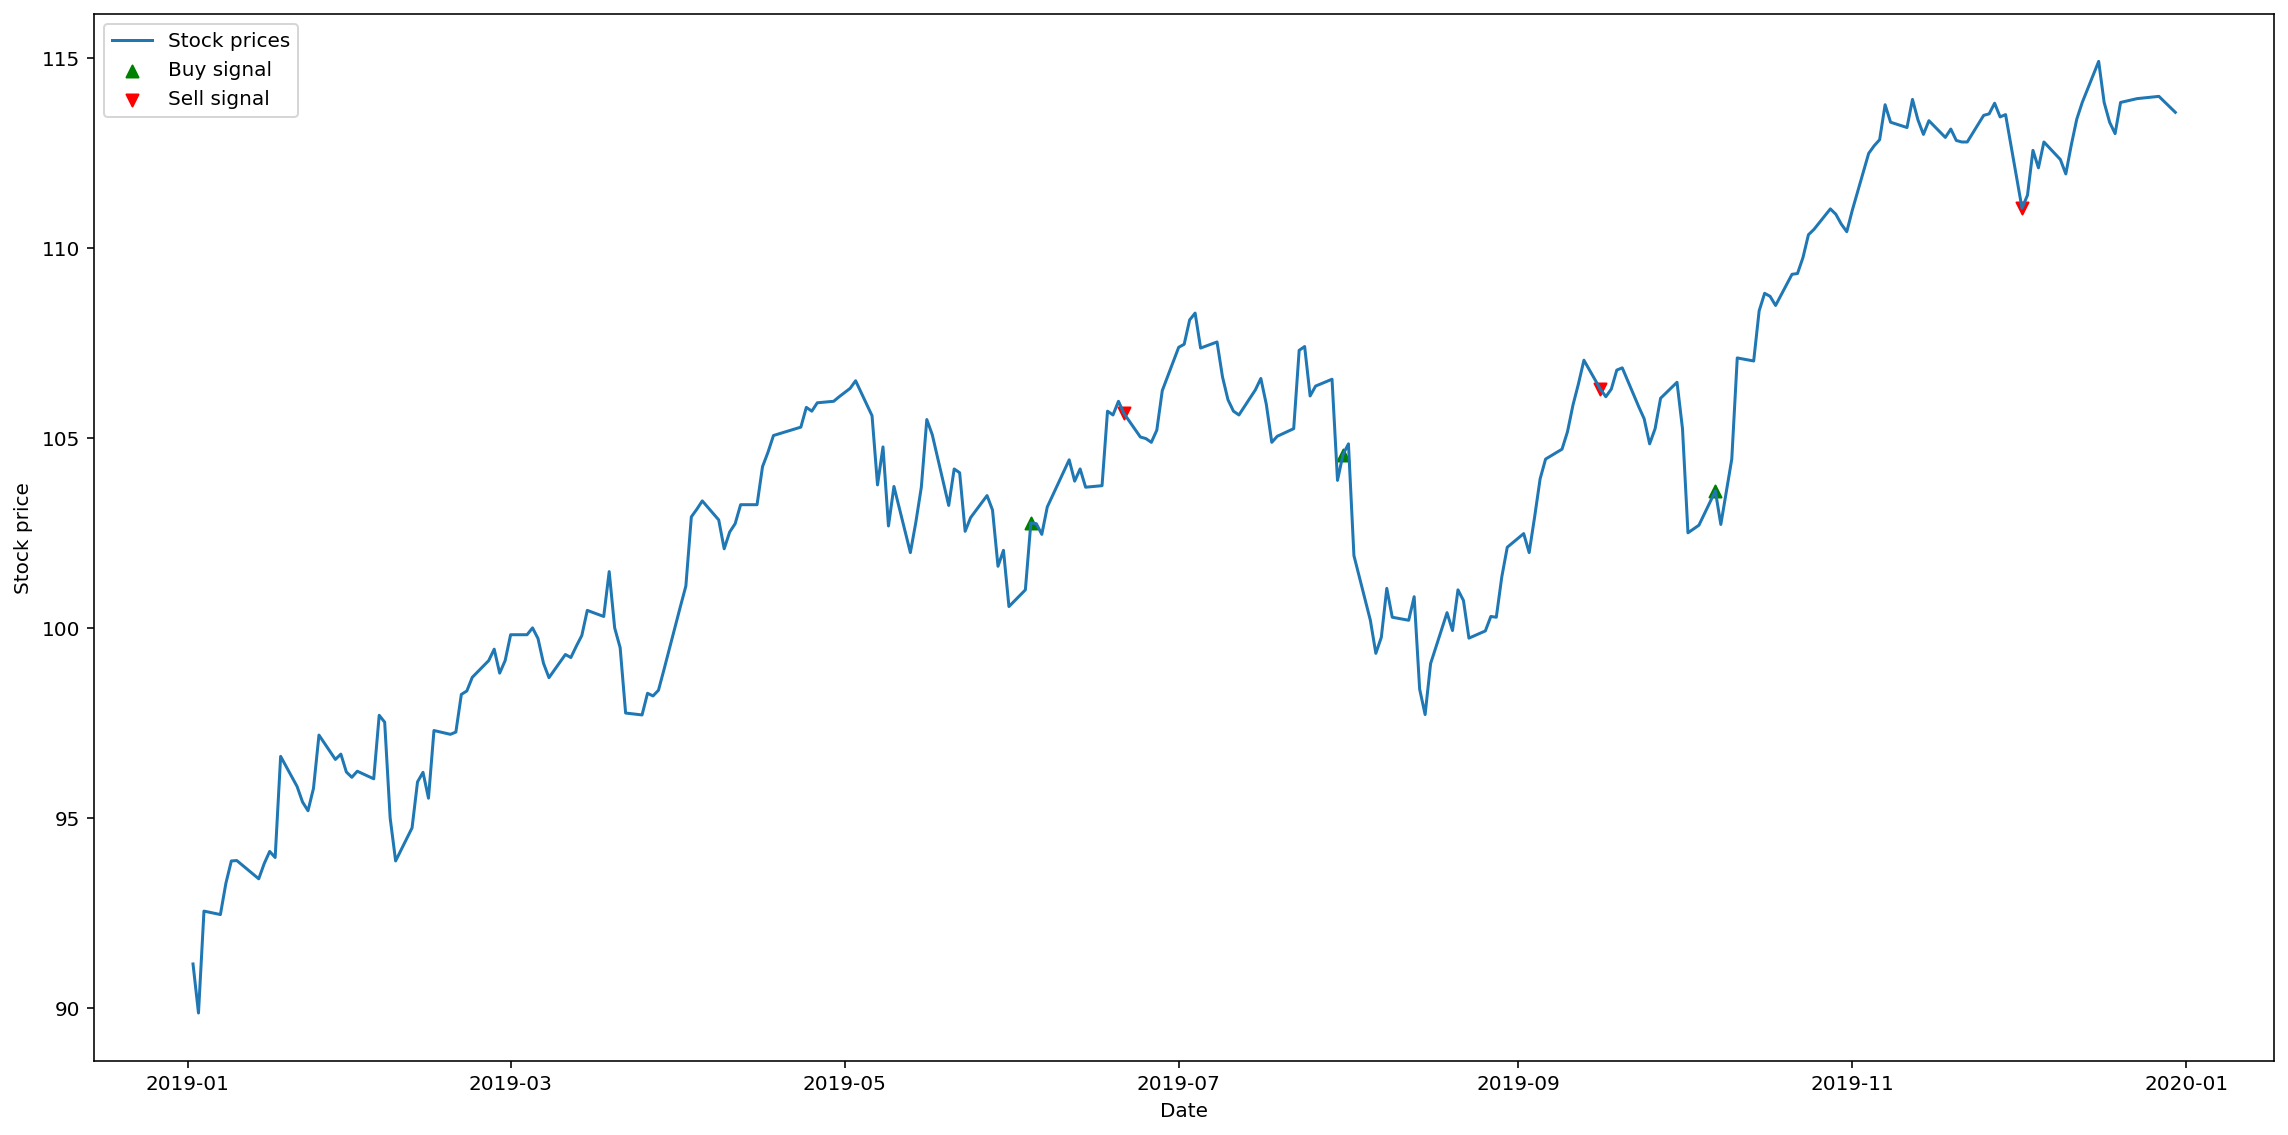

In [9]:
plot_strategy(evaluator, ticker_name='EXS1.DE', start='2019-01-01', end='2019-12-31')

## Adidas

In [10]:
%%time
best_individual = find_best_strategy(ticker_name='ADS.DE', start='2016-01-01', end='2018-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 10 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-154.613	94.8027	-4.46141	35.9584
1  	731   	-80.3103	88.8497	18.5164 	27.0102
Net profit of buy and hold: 95.468225
Running backtesting ...
Best individual: [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0]
Best average net profit: 36.243068264533
--------------------
Iteration 2 of 10 with best cv score: 36.243068264533
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-154.613	94.8027	-4.46141	35.9584
1  	731   	-80.3103	88.8497	18.5164 	27.0102
2  	693   	-156.036	95.0996	33.8371 	26.3696
Net profit of buy and hol

Best individual: [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
Best average net profit: 45.78655917532555
--------------------
Iteration 11 of 10 with best cv score: 45.78655917532555
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-154.613	94.8027	-4.46141	35.9584
1  	731   	-80.3103	88.8497	18.5164 	27.0102
2  	693   	-156.036	95.0996	33.8371 	26.3696
3  	732   	-129.626	101.916	45.0693 	25.0588
4  	728   	-132.923	112.837	54.9181 	26.8473
5  	736   	-92.54  	119.252	62.5018 	27.0326
6  	732   	-127.862	119.252	70.4196 	25.6045
7  	768   	-135.621	119.252	74.3959 	28.7845
8  	718   	-47.2129	119.252	79.9916 	24.999 
9  	701   	-131.66 	125.661	83.4941 	26.9115
10 	732   	-135.621	124.316	85.2725 	28.7082
11 

9  	701   	-131.66 	125.661	83.4941 	26.9115
10 	732   	-135.621	124.316	85.2725 	28.7082
11 	724   	-80.3103	124.766	88.084  	26.5951
12 	702   	-78.6644	136.696	89.3562 	29.1086
13 	697   	-67.6136	136.696	89.7473 	32.2394
14 	728   	-141.237	136.899	91.225  	33.9638
15 	722   	-138.139	145.219	89.5368 	37.9154
16 	691   	-143.017	145.219	92.9333 	37.0705
17 	734   	-141.237	146.635	91.9084 	42.1551
Net profit of buy and hold: 95.468225
Running backtesting ...
Best individual: [1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
Best average net profit: 34.4271663595597
--------------------
Iteration 18 of 10 with best cv score: 45.78655917532555
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-154.613	94.8027	-4.4

In [11]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='ADS.DE', start='2019-01-01', end='2019-12-31')
results['ADS.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[4, 71, 93], [59, 4]]
Net profit of strategy: 35.721825
Net profit of buy and hold: 104.593925
Percentage profit of strategy: 20.030181%
Percentage profit of buy and hold: 58.648607%
Number of buy signals: 5
Number of sell signals: 5


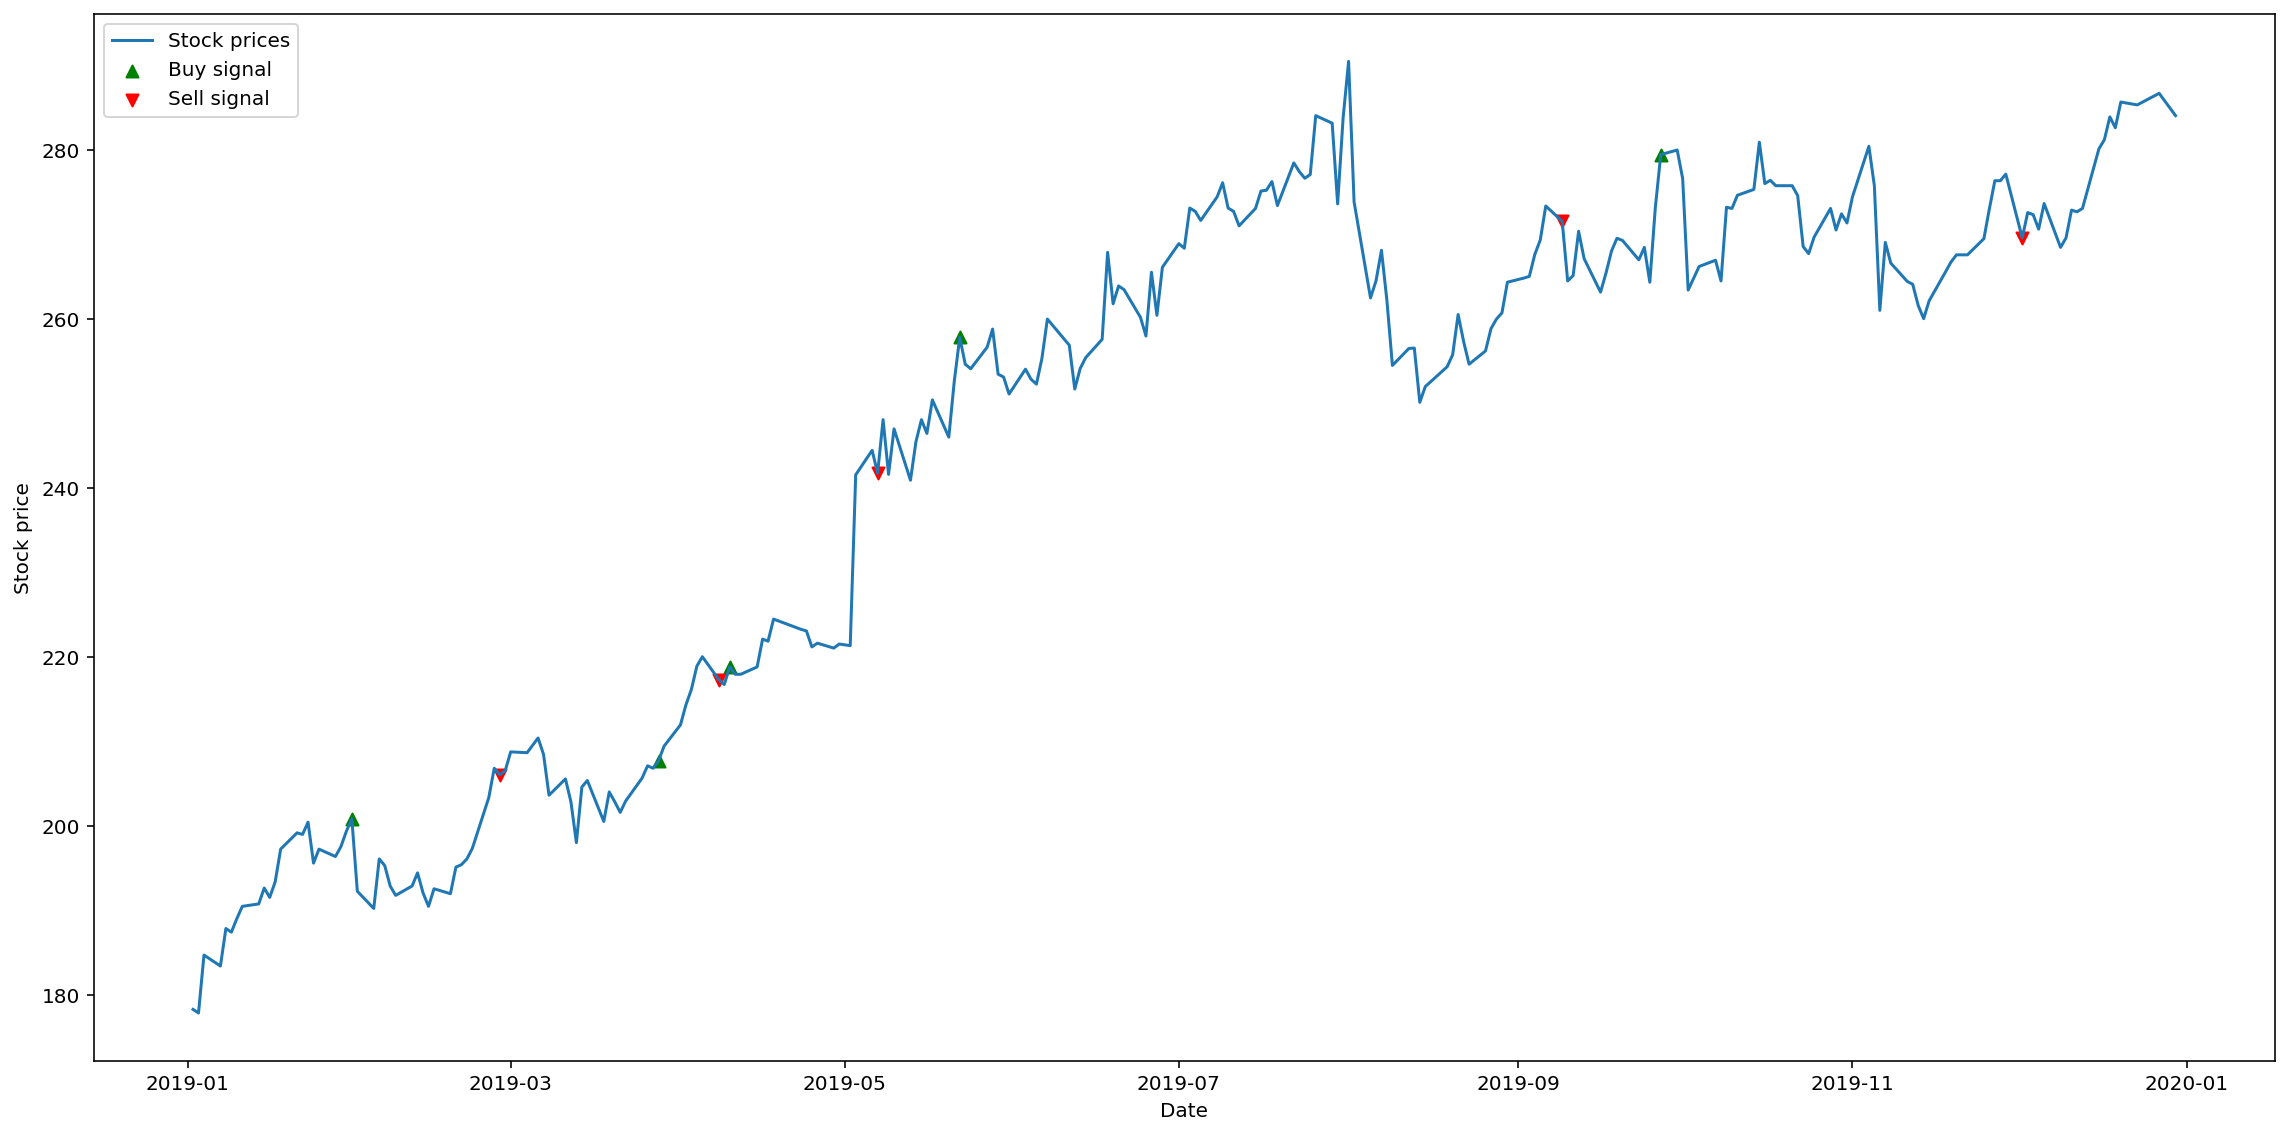

In [12]:
plot_strategy(evaluator, ticker_name='ADS.DE', start='2019-01-01', end='2019-12-31')

## Allianz

In [13]:
%%time
best_individual = find_best_strategy(ticker_name='ALV.DE', start='2016-01-01', end='2018-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 10 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min    	max    	mean    	std    
0  	1000  	-144.68	47.3148	-18.9056	23.3736
1  	731   	-115.453	56.423 	-4.31258	18.0011
Net profit of buy and hold: 40.68527499999999
Running backtesting ...
Best individual: [1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1]
Best average net profit: 4.3757411390518755
--------------------
Iteration 2 of 10 with best cv score: 4.3757411390518755
Running genetic algorithm ...
gen	nevals	min    	max    	mean    	std    
0  	1000  	-144.68	47.3148	-18.9056	23.3736
1  	731   	-115.453	56.423 	-4.31258	18.0011
2  	693   	-121.845	53.7135	5.02989 	17.8957
Net profit of b

Best individual: [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
Best average net profit: 18.6007156100657
--------------------
Iteration 11 of 10 with best cv score: 18.6007156100657
Running genetic algorithm ...
gen	nevals	min    	max    	mean    	std    
0  	1000  	-144.68	47.3148	-18.9056	23.3736
1  	731   	-115.453	56.423 	-4.31258	18.0011
2  	693   	-121.845	53.7135	5.02989 	17.8957
3  	732   	-58.8245	56.423 	12.7925 	17.7901
4  	728   	-117.509	56.423 	20.3608 	18.7475
5  	736   	-58.4529	85.3045	26.2874 	19.4999
6  	732   	-113.269	85.3045	32.3214 	19.6355
7  	768   	-115.619	85.3045	37.5371 	21.1602
8  	718   	-120.132	85.3045	43.762  	19.6145
9  	701   	-113.643	78.5792	47.6461 	19.0732
10 	732   	-69.7982	78.5792	49.7495 	19.4951
11 	724

9  	701   	-113.643	78.5792	47.6461 	19.0732
10 	732   	-69.7982	78.5792	49.7495 	19.4951
11 	724   	-113.269	80.5327	53.7293 	17.761 
12 	702   	-36.5476	85.2317	56.166  	17.6348
13 	697   	-54.8149	85.2317	57.185  	20.0191
14 	728   	-113.269	85.6338	58.5204 	20.1195
15 	722   	-58.5546	85.6338	59.3891 	20.5697
16 	691   	-59.0593	85.6338	61.9121 	20.6698
17 	734   	-29.5072	85.6338	64.2181 	19.8062
Net profit of buy and hold: 40.68527499999999
Running backtesting ...
Best individual: [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
Best average net profit: 18.6007156100657
--------------------
Iteration 18 of 10 with best cv score: 18.6007156100657
Running genetic algorithm ...
gen	nevals	min    	max    	mean    	std    
0  	1000  	-144.68	47.3148

In [14]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='ALV.DE', start='2019-01-01', end='2019-12-31')
results['ALV.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[12, 51, 120], [61, 7]]
Net profit of strategy: 31.475325
Net profit of buy and hold: 47.002725
Percentage profit of strategy: 19.984333%
Percentage profit of buy and hold: 29.843000%
Number of buy signals: 5
Number of sell signals: 5


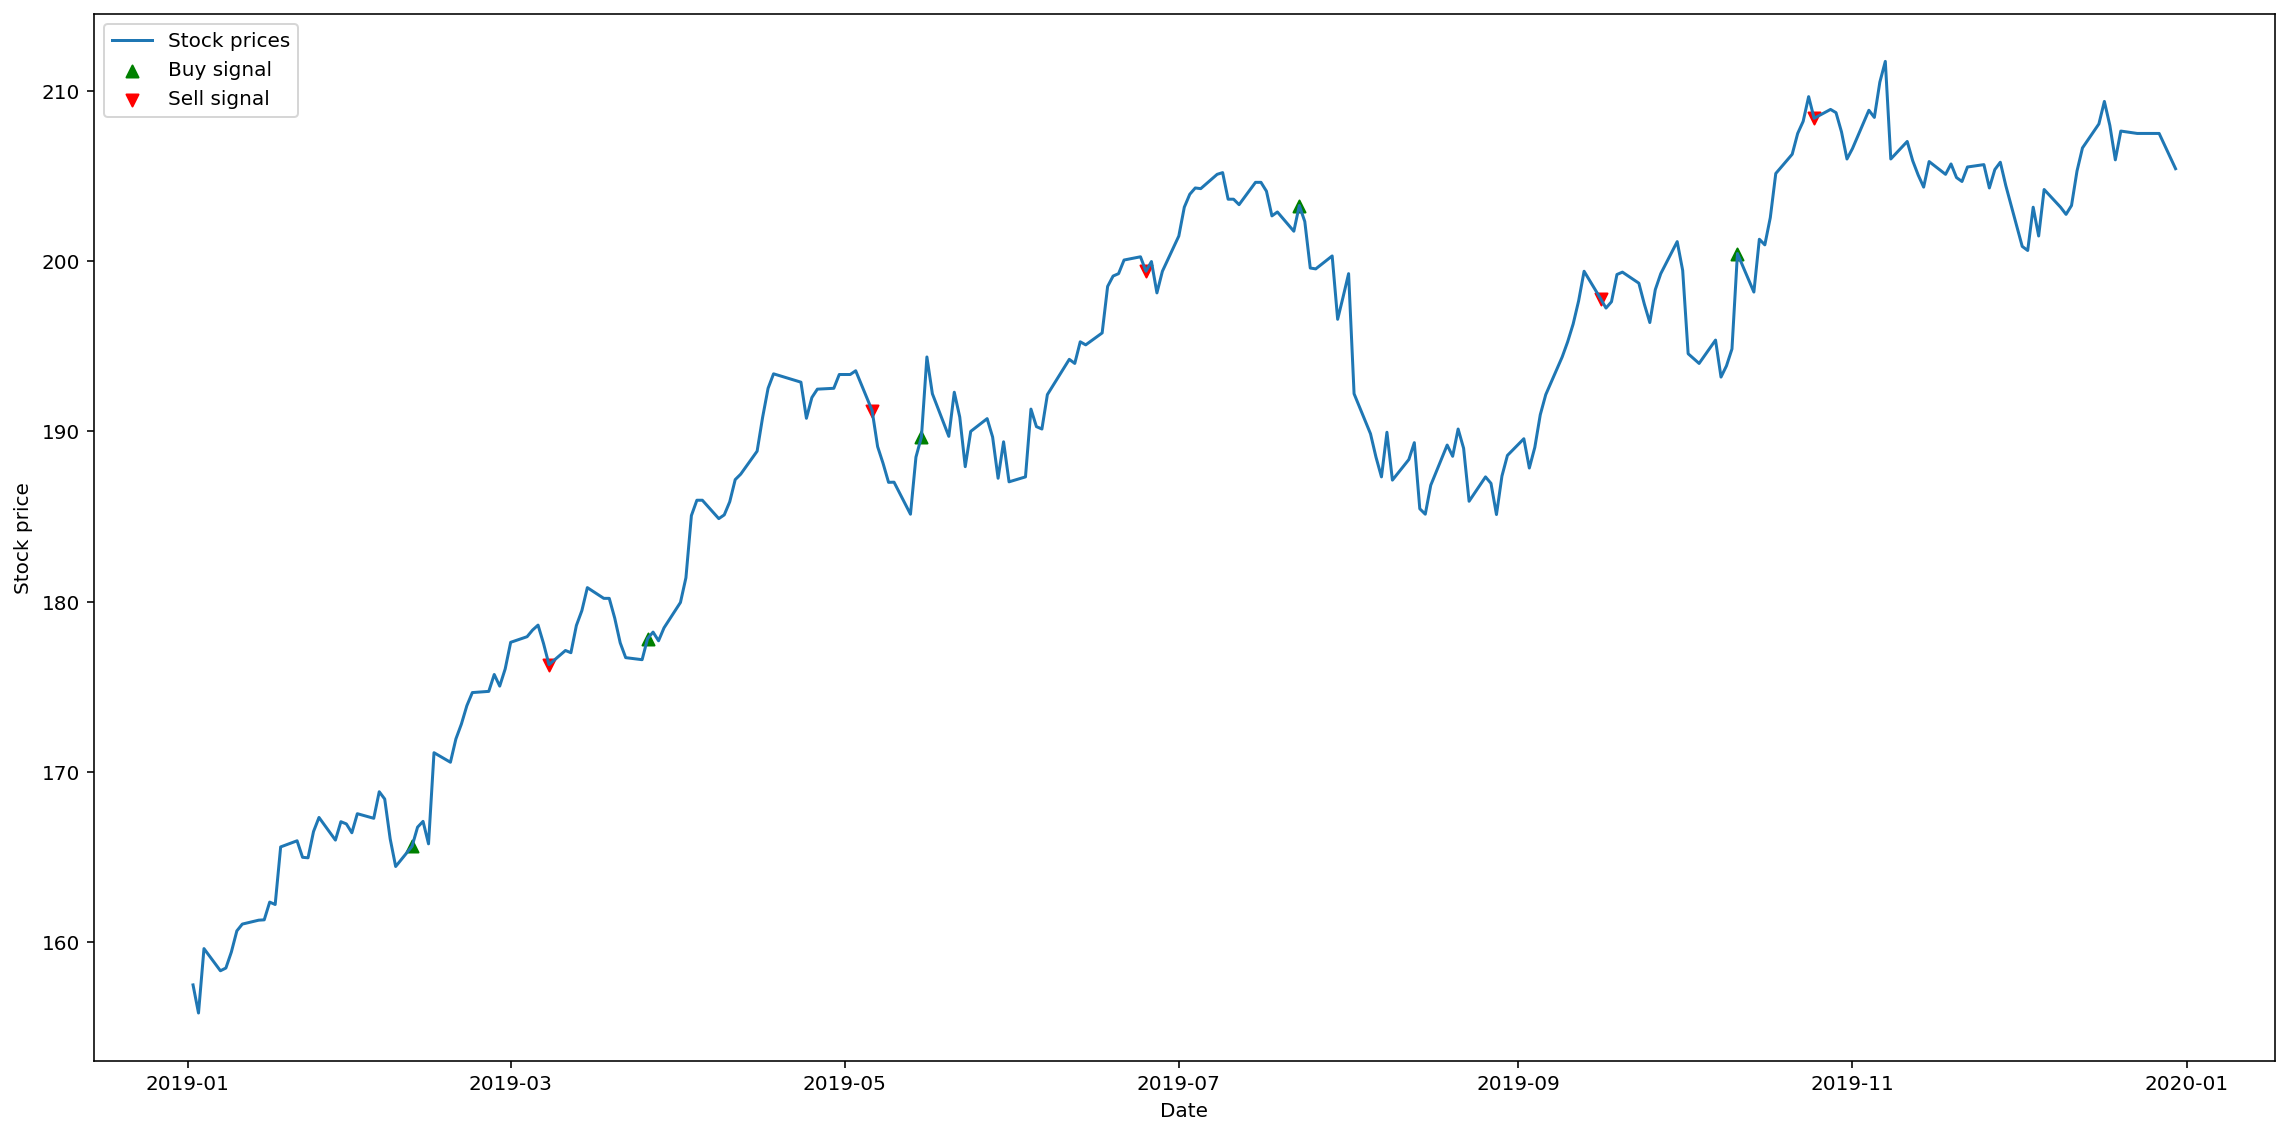

In [15]:
plot_strategy(evaluator, ticker_name='ALV.DE', start='2019-01-01', end='2019-12-31')

## BASF

In [16]:
%%time
best_individual = find_best_strategy(ticker_name='BAS.DE', start='2016-01-01', end='2018-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 10 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-67.1786	17.4502	-12.4406	12.3205
1  	731   	-63.9956	21.1967	-4.62301	9.7486 
Net profit of buy and hold: -0.29204999999999914
Running backtesting ...
Best individual: [1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1]
Best average net profit: -0.2065417283917726
--------------------
Iteration 2 of 10 with best cv score: -0.2065417283917726
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-67.1786	17.4502	-12.4406	12.3205
1  	731   	-63.9956	21.1967	-4.62301	9.7486 
2  	693   	-58.7963	23.1415	0.845654	8.42652
Net pr

9  	701   	-58.7963	34.2378	18.8463 	10.8282
10 	732   	-58.7963	34.259 	20.7201 	11.9077
Net profit of buy and hold: -0.29204999999999914
Running backtesting ...
Best individual: [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0]
Best average net profit: 1.7060575759518068
--------------------
Iteration 11 of 10 with best cv score: 1.7060575759518068
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-67.1786	17.4502	-12.4406	12.3205
1  	731   	-63.9956	21.1967	-4.62301	9.7486 
2  	693   	-58.7963	23.1415	0.845654	8.42652
3  	732   	-68.7631	26.8883	4.40702 	9.26637
4  	728   	-69.5671	26.8883	7.29952 	9.13642
5  	736   	-59.2563	26.9266	10.0356 	9.33702
6  	732   	-58.7963	34.2378	11.8891 	10.1574
7  	768   	-58.796

4  	728   	-69.5671	26.8883	7.29952 	9.13642
5  	736   	-59.2563	26.9266	10.0356 	9.33702
6  	732   	-58.7963	34.2378	11.8891 	10.1574
7  	768   	-58.7963	34.2378	13.2849 	10.8139
8  	718   	-58.7963	34.2378	15.9145 	10.7155
9  	701   	-58.7963	34.2378	18.8463 	10.8282
10 	732   	-58.7963	34.259 	20.7201 	11.9077
11 	724   	-60.0206	34.259 	22.6193 	10.9137
12 	702   	-62.9671	34.708 	23.8567 	11.3563
13 	697   	-58.7963	35.0294	24.4662 	11.967 
14 	728   	-58.7963	35.0294	24.9087 	13.0443
15 	722   	-58.7963	35.0294	25.5132 	14.2086
16 	691   	-33.9575	35.0294	27.696  	12.2157
17 	734   	-58.7963	35.0294	27.0752 	14.464 
Net profit of buy and hold: -0.29204999999999914
Running backtesting ...
Best individual: [0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 

In [17]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='BAS.DE', start='2019-01-01', end='2019-12-31')
results['BAS.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[31, 43, 110], [3, 5]]
Net profit of strategy: 0.000000
Net profit of buy and hold: 7.846450
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: 15.491510%
Number of buy signals: 0
Number of sell signals: 0


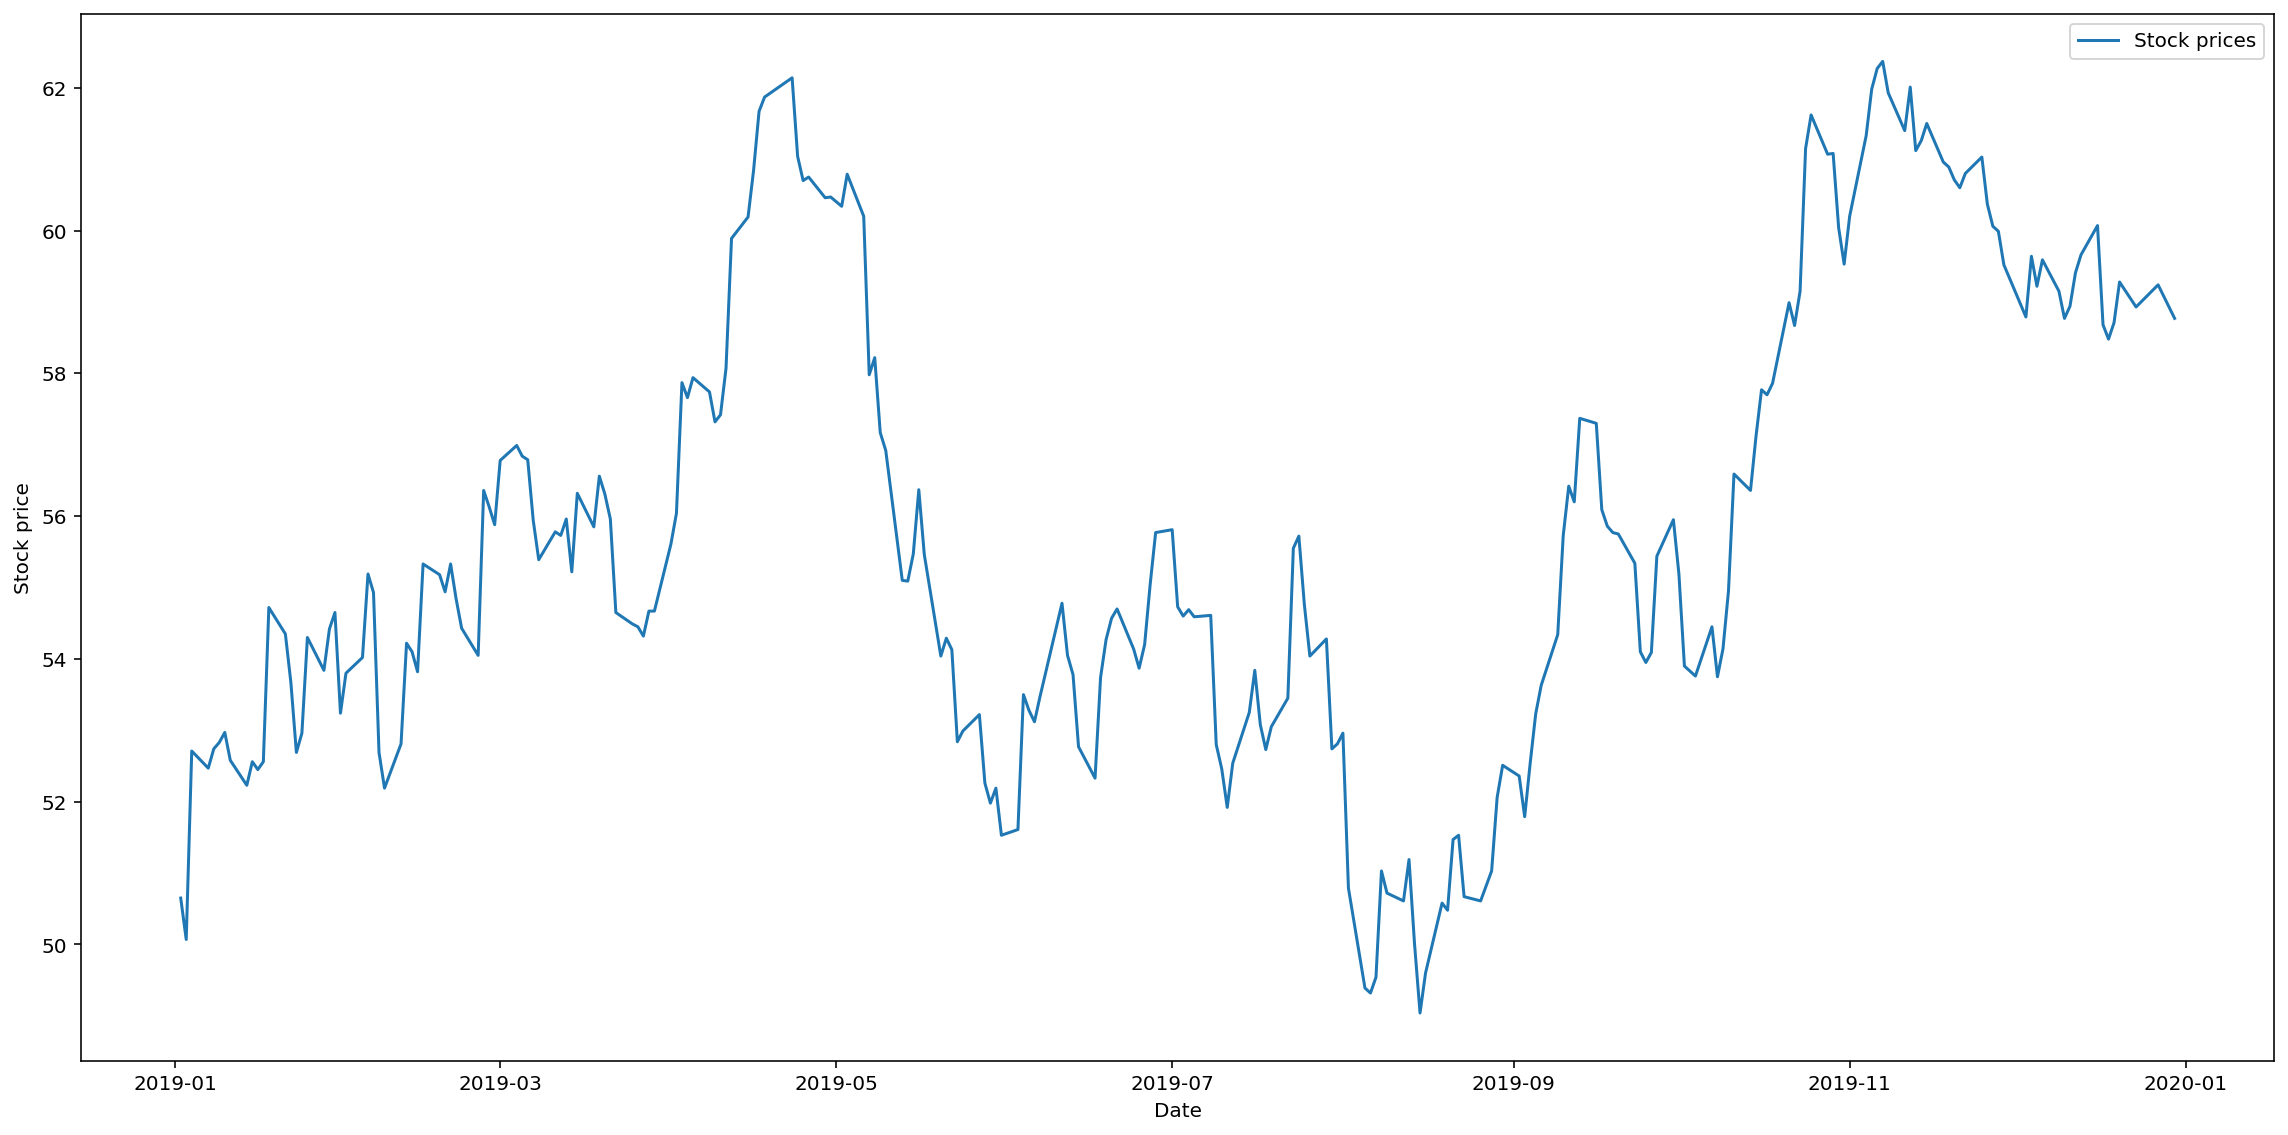

In [18]:
plot_strategy(evaluator, ticker_name='BAS.DE', start='2019-01-01', end='2019-12-31')

## Deutsche Bank

In [19]:
%%time
best_individual = find_best_strategy(ticker_name='DBK.DE', start='2016-01-01', end='2018-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 10 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std   
0  	1000  	-15.7653	2.97725	-4.7023	3.2932
1  	731   	-13.8199	3.63205	-2.69067	2.79076
Net profit of buy and hold: -11.62315
Running backtesting ...
Best individual: [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Best average net profit: -0.04611845879461943
--------------------
Iteration 2 of 10 with best cv score: -0.04611845879461943
Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std   
0  	1000  	-15.7653	2.97725	-4.7023	3.2932
1  	731   	-13.8199	3.63205	-2.69067	2.79076
2  	693   	-13.676 	5.8388 	-1.29094	2.3747 
Net profit of buy and h

Best individual: [1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
Best average net profit: -0.2939745591265101
--------------------
Iteration 11 of 10 with best cv score: -0.007634412149811617
Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std   
0  	1000  	-15.7653	2.97725	-4.7023	3.2932
1  	731   	-13.8199	3.63205	-2.69067	2.79076
2  	693   	-13.676 	5.8388 	-1.29094	2.3747 
3  	732   	-10.1599	5.81635	-0.3485 	2.26073
4  	728   	-11.8903	9.39517	0.13787 	2.45803
5  	736   	-13.4124	9.39517	0.534795	2.57124
6  	732   	-14.1071	6.90175	1.02392 	2.62438
7  	768   	-11.418 	8.5694 	1.39419 	2.85635
8  	718   	-11.7123	9.94975	2.01438 	2.9885 
9  	701   	-11.4646	10.1814	2.61189 	3.19087
10 	732   	-10.7945	10.477 	3.22025 	3.34137
1

9  	701   	-11.4646	10.1814	2.61189 	3.19087
10 	732   	-10.7945	10.477 	3.22025 	3.34137
11 	724   	-11.2768	10.477 	3.79148 	3.48493
12 	702   	-11.3989	11.7194	4.90788 	3.26288
13 	697   	-10.9941	11.7194	5.59781 	3.53061
14 	728   	-10.1199	11.7194	6.36804 	3.51556
15 	722   	-13.5871	11.7745	6.71566 	4.11759
16 	691   	-10.646 	12.2733	7.68504 	3.83931
17 	734   	-9.161  	12.5841	7.94366 	3.96934
Net profit of buy and hold: -11.62315
Running backtesting ...
Best individual: [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0]
Best average net profit: -0.481971418706349
--------------------
Iteration 18 of 10 with best cv score: -0.007634412149811617
Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std   
0  	1000  	-15.7653	2.97725	

In [20]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DBK.DE', start='2019-01-01', end='2019-12-31')
results['DBK.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[118, 44, 108], [176], [25, 6]]
Net profit of strategy: -0.232900
Net profit of buy and hold: -0.144875
Percentage profit of strategy: -3.312945%
Percentage profit of buy and hold: -2.060811%
Number of buy signals: 2
Number of sell signals: 2


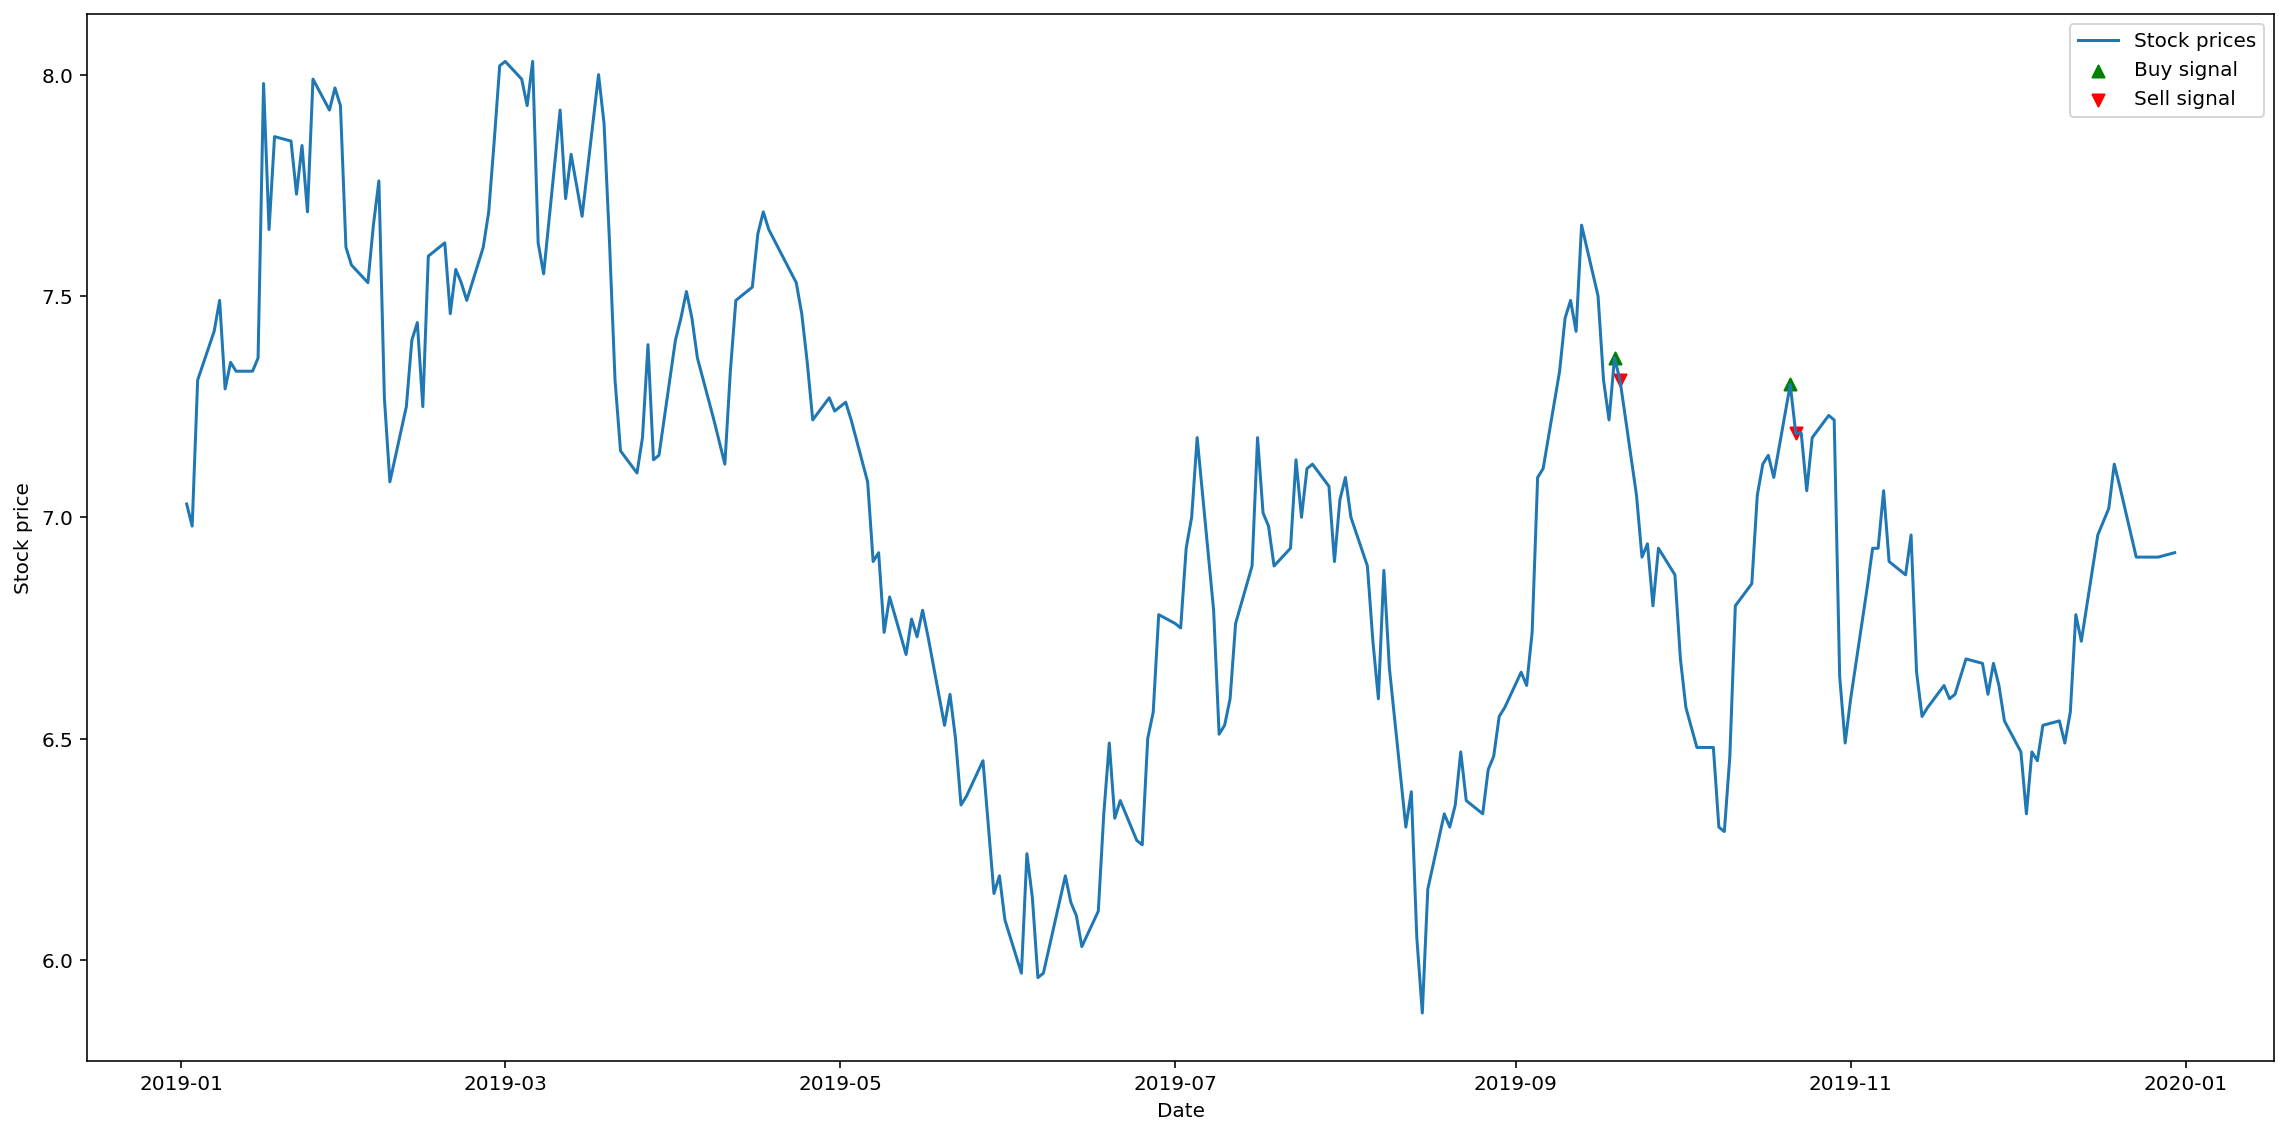

In [21]:
plot_strategy(evaluator, ticker_name='DBK.DE', start='2019-01-01', end='2019-12-31')

## Deutsche Telekom

In [22]:
%%time
best_individual = find_best_strategy(ticker_name='DTE.DE', start='2016-01-01', end='2018-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 10 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max  	mean    	std    
0  	1000  	-10.7461	2.826	-3.02285	2.24222
1  	731   	-10.8318	2.826	-1.44041	1.88254
Net profit of buy and hold: 1.6496749999999991
Running backtesting ...
Best individual: [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Best average net profit: 0.0
--------------------
Iteration 2 of 10 with best cv score: 0.0
Running genetic algorithm ...
gen	nevals	min     	max  	mean    	std    
0  	1000  	-10.7461	2.826	-3.02285	2.24222
1  	731   	-10.8318	2.826	-1.44041	1.88254
2  	693   	-10.2007	3.75125	-0.357609	1.58438
Net profit of buy and hold: 1.6496749999999991
Runn

10 	732   	-10.2433	5.31915	3.3459   	2.09924
Net profit of buy and hold: 1.6496749999999991
Running backtesting ...
Best individual: [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1]
Best average net profit: 0.26076003527644914
--------------------
Iteration 11 of 10 with best cv score: 0.7529053230925649
Running genetic algorithm ...
gen	nevals	min     	max  	mean    	std    
0  	1000  	-10.7461	2.826	-3.02285	2.24222
1  	731   	-10.8318	2.826	-1.44041	1.88254
2  	693   	-10.2007	3.75125	-0.357609	1.58438
3  	732   	-5.75385	4.14698	0.380388 	1.36025
4  	728   	-9.85022	4.0246 	0.810758 	1.50945
5  	736   	-9.89428	4.96212	1.20319  	1.71389
6  	732   	-9.65212	4.96212	1.7502   	1.80111
7  	768   	-10.3976	5.10762	2.24385  	1.82486
8  	718   	-10.466

4  	728   	-9.85022	4.0246 	0.810758 	1.50945
5  	736   	-9.89428	4.96212	1.20319  	1.71389
6  	732   	-9.65212	4.96212	1.7502   	1.80111
7  	768   	-10.3976	5.10762	2.24385  	1.82486
8  	718   	-10.4667	5.2995 	2.73024  	1.88662
9  	701   	-9.969  	5.10762	3.07439  	2.0096 
10 	732   	-10.2433	5.31915	3.3459   	2.09924
11 	724   	-8.97967	6.0612 	3.78642  	1.93194
12 	702   	-5.45125	6.0612 	4.01235  	1.8779 
13 	697   	-7.02332	6.0612 	4.00818  	2.02723
14 	728   	-9.73805	6.0612 	4.12087  	2.07089
15 	722   	-5.99938	6.0612 	4.1311   	1.93456
16 	691   	-8.97967	6.0612 	4.22689  	1.99947
17 	734   	-9.85022	6.0612 	4.21161  	2.03142
Net profit of buy and hold: 1.6496749999999991
Running backtesting ...
Best individual: [1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 

In [23]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DTE.DE', start='2019-01-01', end='2019-12-31')
results['DTE.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[9, 36, 110], [42, 3]]
Net profit of strategy: -0.102825
Net profit of buy and hold: 0.314450
Percentage profit of strategy: -0.795859%
Percentage profit of buy and hold: 2.433824%
Number of buy signals: 2
Number of sell signals: 2


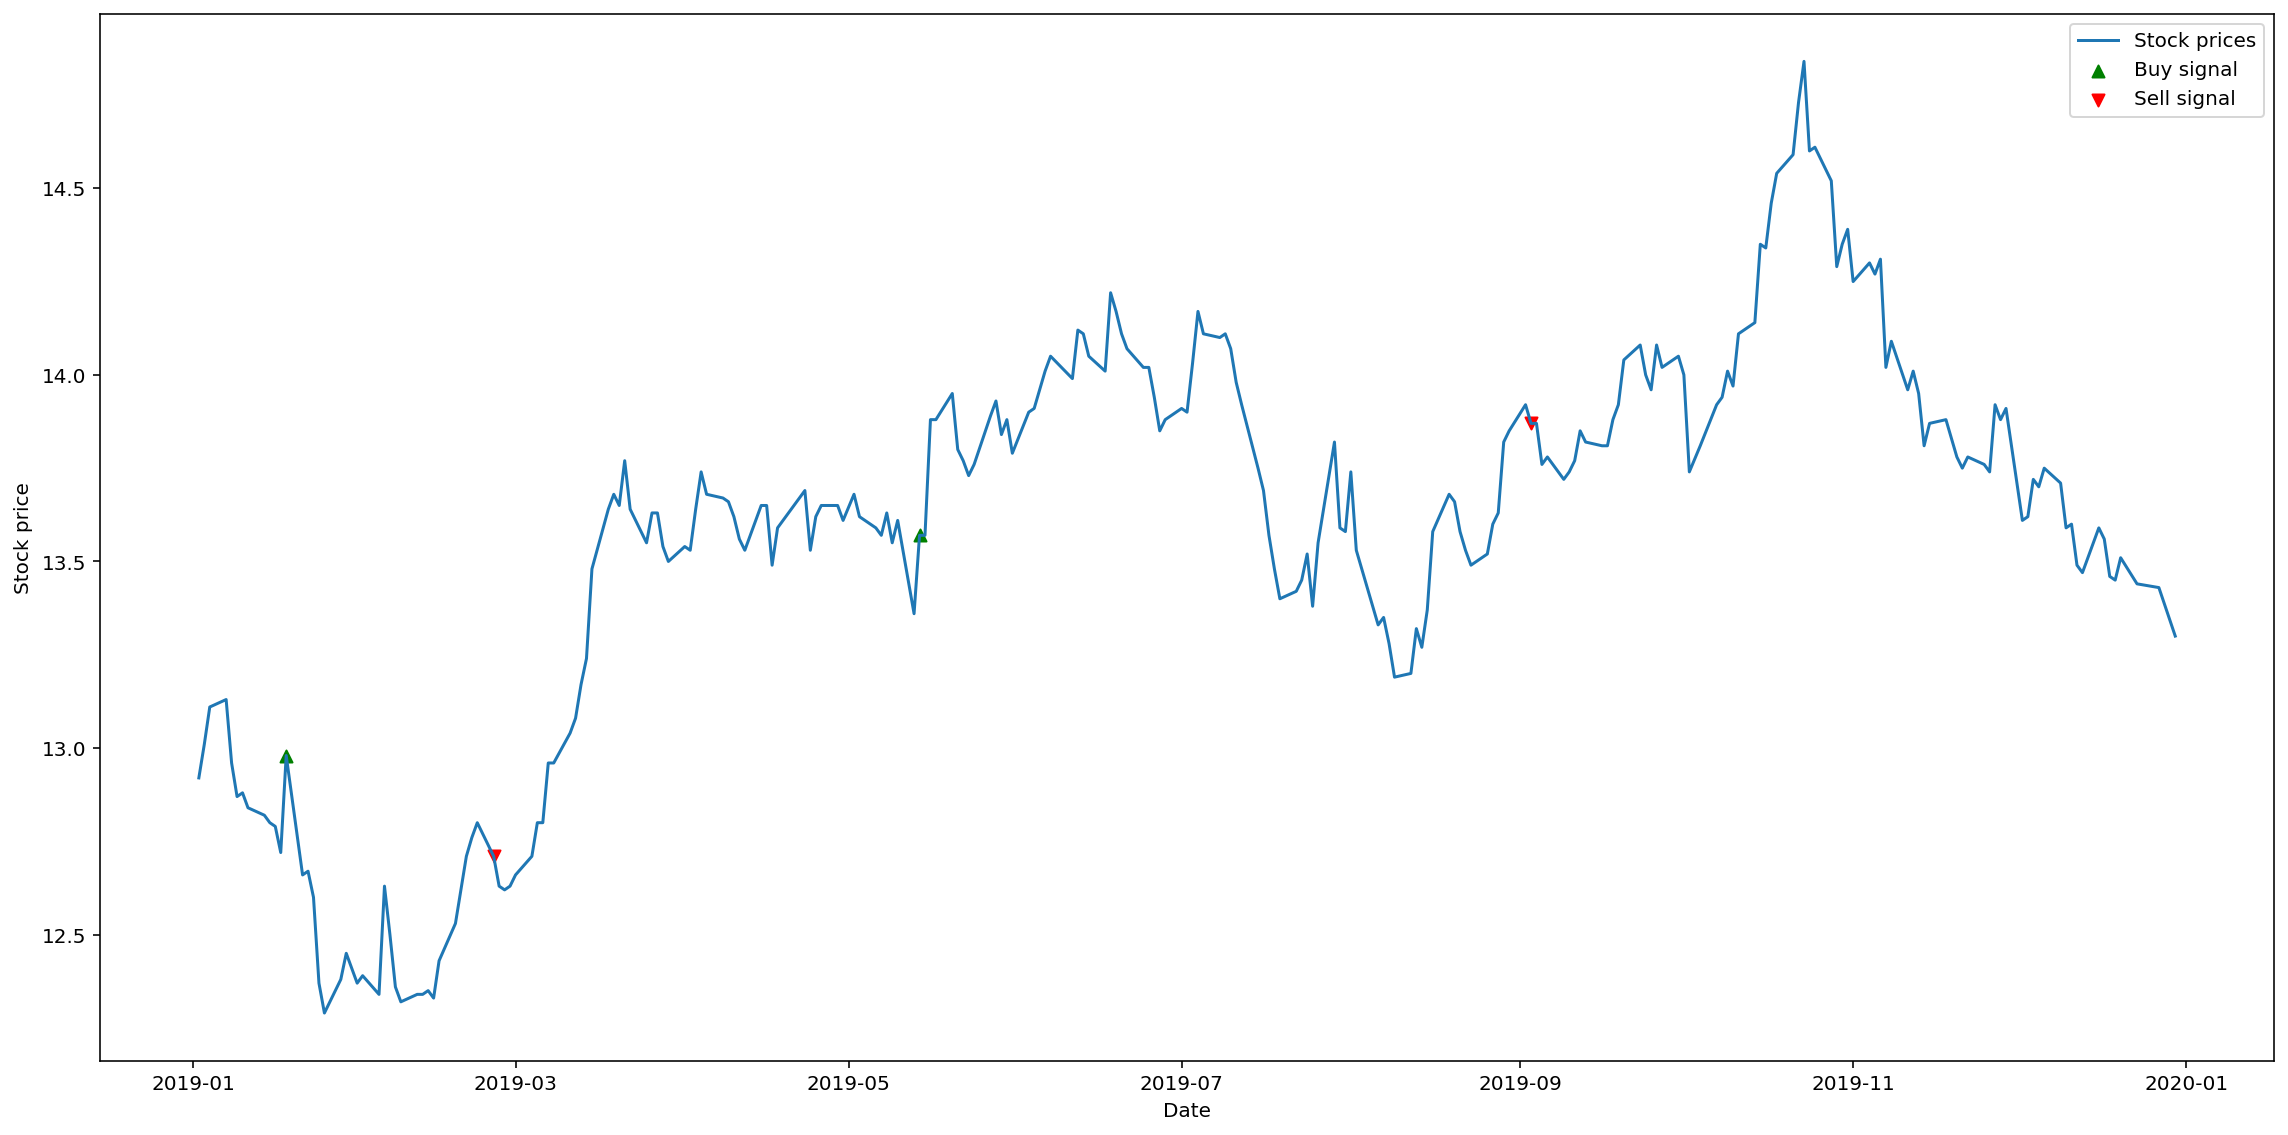

In [24]:
plot_strategy(evaluator, ticker_name='DTE.DE', start='2019-01-01', end='2019-12-31')

## SAP

In [25]:
%%time
best_individual = find_best_strategy(ticker_name='SAP.DE', start='2016-01-01', end='2018-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 10 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-79.7186	26.6214	-13.8564	16.2574
1  	731   	-75.559 	26.6214	-2.84961	11.8627
Net profit of buy and hold: 18.250100000000003
Running backtesting ...
Best individual: [0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1]
Best average net profit: 0.6536610349267538
--------------------
Iteration 2 of 10 with best cv score: 0.6536610349267538
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-79.7186	26.6214	-13.8564	16.2574
1  	731   	-75.559 	26.6214	-2.84961	11.8627
2  	693   	-77.6088	26.6214	3.86998 	9.65979
Net profit

10 	732   	-75.559 	48.3655	20.1541 	13.6219
Net profit of buy and hold: 18.250100000000003
Running backtesting ...
Best individual: [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]
Best average net profit: 3.0526887444267317
--------------------
Iteration 11 of 10 with best cv score: 6.888234740286447
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-79.7186	26.6214	-13.8564	16.2574
1  	731   	-75.559 	26.6214	-2.84961	11.8627
2  	693   	-77.6088	26.6214	3.86998 	9.65979
3  	732   	-72.3062	29.9904	7.34115 	11.2872
4  	728   	-77.2148	29.9904	10.4799 	12.1346
5  	736   	-72.8054	30.1816	13.6613 	11.2091
6  	732   	-42.4596	37.0555	15.5433 	10.9857
7  	768   	-76.6172	39.0521	16.2422 	13.3926
8  	718   	-73.6686	4

5  	736   	-72.8054	30.1816	13.6613 	11.2091
6  	732   	-42.4596	37.0555	15.5433 	10.9857
7  	768   	-76.6172	39.0521	16.2422 	13.3926
8  	718   	-73.6686	48.3655	17.4748 	13.7796
9  	701   	-75.4453	48.3655	19.5485 	13.2971
10 	732   	-75.559 	48.3655	20.1541 	13.6219
11 	724   	-72.5756	39.3703	21.8859 	13.3813
12 	702   	-40.5329	48.3655	23.6499 	12.8831
13 	697   	-73.2939	48.3655	23.9526 	14.8844
14 	728   	-75.559 	49.368 	25.5723 	14.4577
15 	722   	-72.9826	49.368 	26.015  	14.8015
16 	691   	-74.77  	49.368 	28.8287 	14.1957
17 	734   	-74.77  	49.368 	29.5491 	15.8762
Net profit of buy and hold: 18.250100000000003
Running backtesting ...
Best individual: [1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1]
Best average net profit: 3.80428578570

In [26]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='SAP.DE', start='2019-01-01', end='2019-12-31')
results['SAP.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[9, 36, 107], [58, 6]]
Net profit of strategy: 11.846075
Net profit of buy and hold: 32.969475
Percentage profit of strategy: 14.209038%
Percentage profit of buy and hold: 39.545970%
Number of buy signals: 2
Number of sell signals: 2


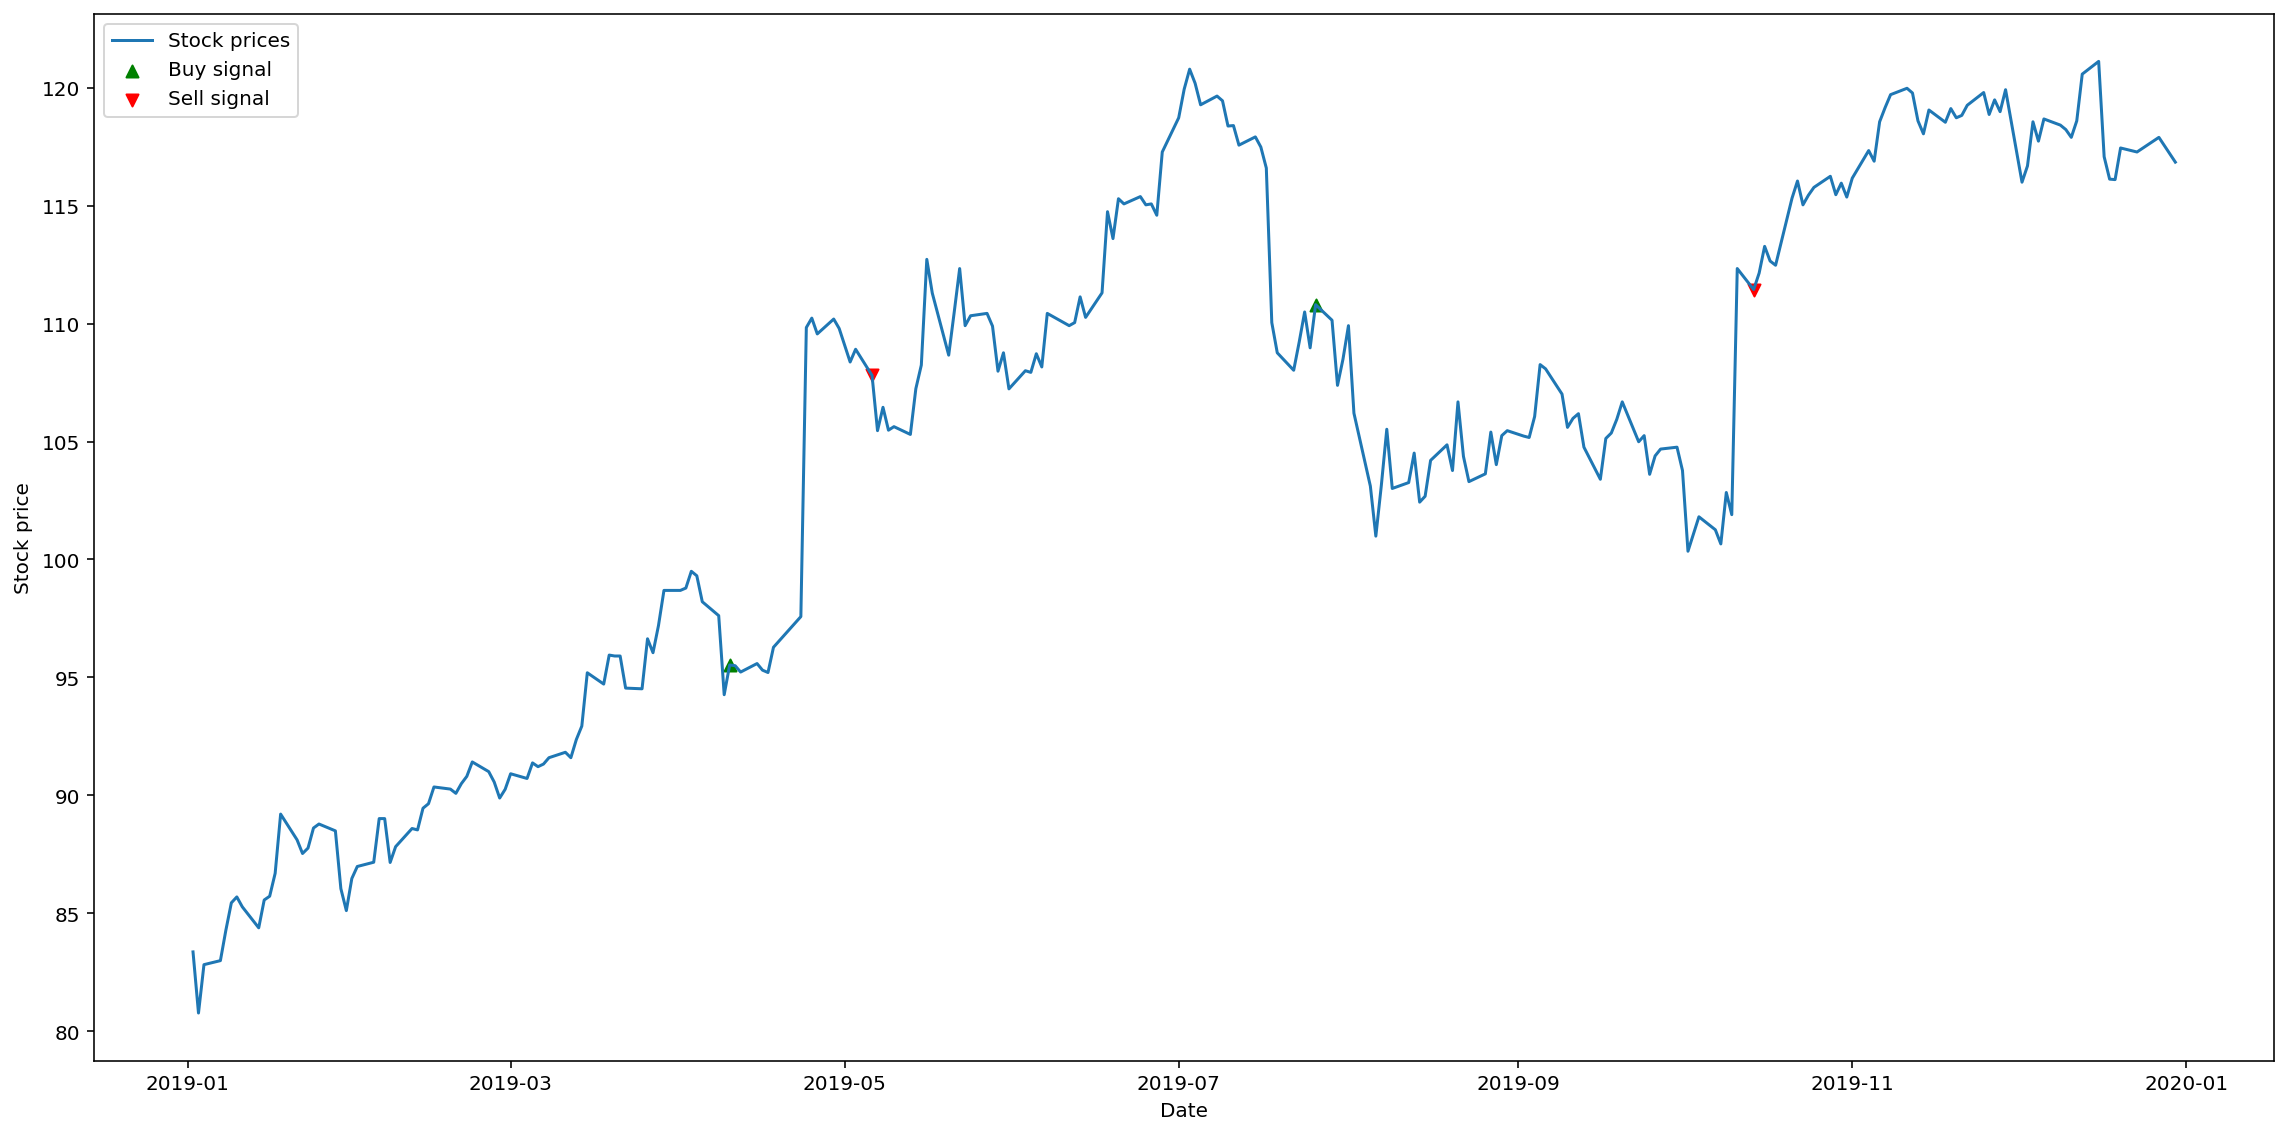

In [27]:
plot_strategy(evaluator, ticker_name='SAP.DE', start='2019-01-01', end='2019-12-31')

## Dow Jones Index

In [28]:
%%time
best_individual = find_best_strategy(ticker_name='DJI', start='2016-01-01', end='2018-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 10 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-17673.4	5972.46	-404.667	3075.28
1  	731   	-17338.5	7497.34	1243.51 	2302.12
Net profit of buy and hold: 5812.97175
Running backtesting ...
Best individual: [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0]
Best average net profit: 1050.5510299467717
--------------------
Iteration 2 of 10 with best cv score: 1050.5510299467717
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-17673.4	5972.46	-404.667	3075.28
1  	731   	-17338.5	7497.34	1243.51 	2302.12
2  	693   	-15804.2	7739.14	2384.9  	2013.78
Net profit of buy 

Best individual: [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]
Best average net profit: 525.4372516113364
--------------------
Iteration 11 of 10 with best cv score: 1050.5510299467717
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-17673.4	5972.46	-404.667	3075.28
1  	731   	-17338.5	7497.34	1243.51 	2302.12
2  	693   	-15804.2	7739.14	2384.9  	2013.78
3  	732   	-14277.9	7532.41	3080.08 	2233.36
4  	728   	-10030.5	8421.21	3817.42 	1874.78
5  	736   	-17074.8	8421.21	4260.11 	2325.39
6  	732   	-10254.9	8421.21	4665.4  	2117.9 
7  	768   	-18104.5	8659.32	4881.61 	2588.7 
8  	718   	-12314.8	9601.51	5351.59 	2396.27
9  	701   	-14155  	9601.51	5741.79 	2458   
10 	732   	-16878.6	9601.51	5886.82 	2510.41
11

9  	701   	-14155  	9601.51	5741.79 	2458   
10 	732   	-16878.6	9601.51	5886.82 	2510.41
11 	724   	-7973.8 	9601.51	6023.96 	2455.34
12 	702   	-5612.92	9601.51	6425.16 	2365.57
13 	697   	-10086.2	9601.51	6388.4  	2772.42
14 	728   	-14511  	9601.51	6673.68 	2728.49
15 	722   	-13602.4	9601.51	6724.51 	2927.16
16 	691   	-14816.7	9601.51	7068.67 	2877.21
17 	734   	-14507.7	9601.51	7512.53 	2768.2 
Net profit of buy and hold: 5812.97175
Running backtesting ...
Best individual: [1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1]
Best average net profit: -1042.7418619888801
--------------------
Iteration 18 of 10 with best cv score: 1050.5510299467717
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-17673.4	5972.46

In [29]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DJI', start='2019-01-01', end='2019-12-31')
results['DJI'].append([percentage_profit, percentage_profit_bh])

Active rules: ['ExponentialMovingAverage', 'STO', 'RSI', 'BollingerBaender']
Active rules' parameters: [[239], [17, 194], [10, 115, 15], [26, 7]]
Net profit of strategy: 0.000000
Net profit of buy and hold: 2519.888500
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: 10.796114%
Number of buy signals: 0
Number of sell signals: 0


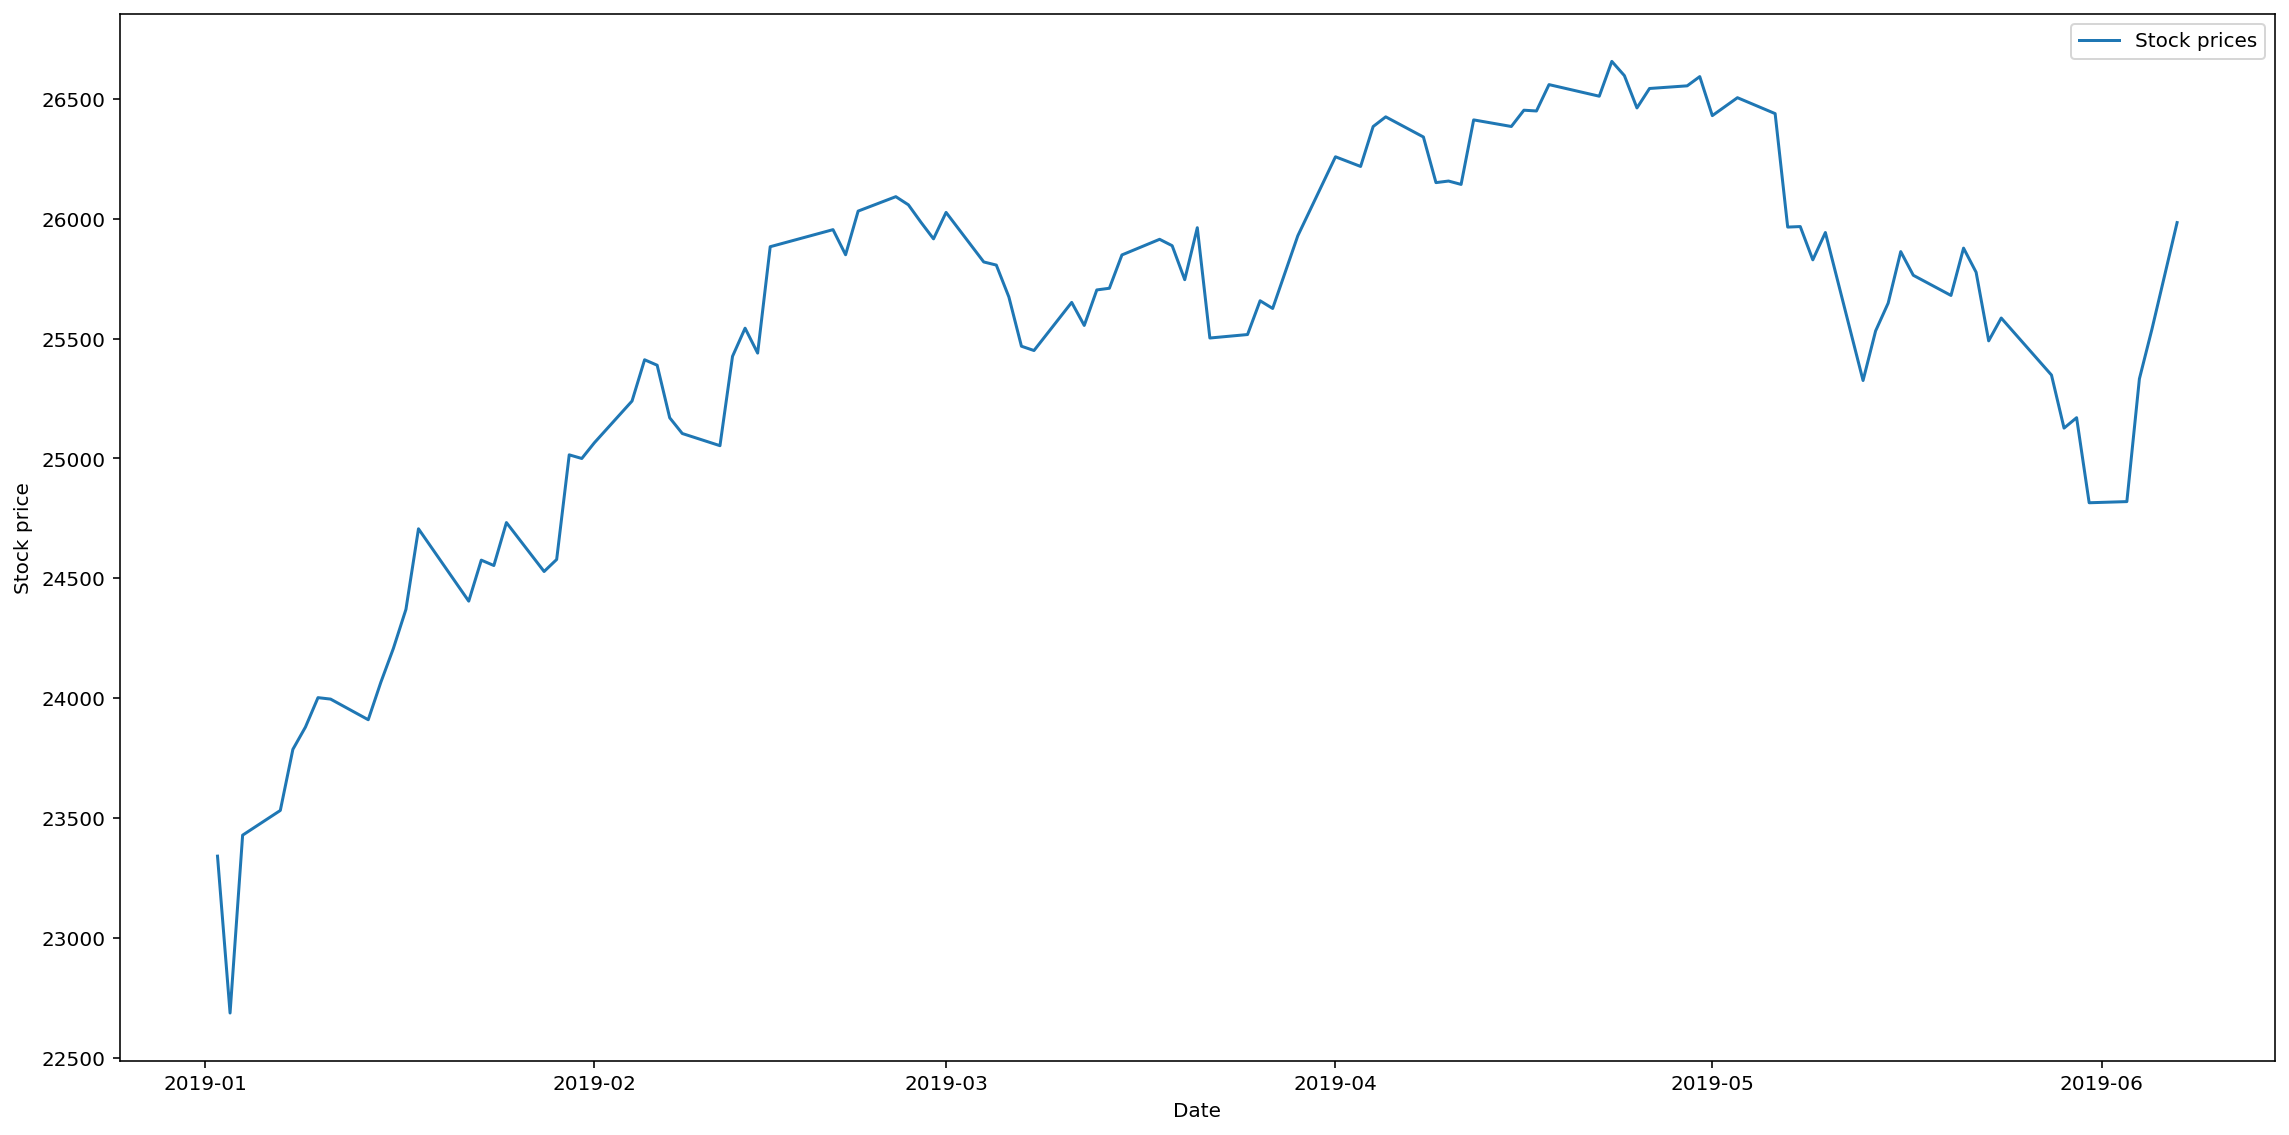

In [30]:
plot_strategy(evaluator, ticker_name='DJI', start='2019-01-01', end='2019-12-31')

## Cisco

In [31]:
%%time
best_individual = find_best_strategy(ticker_name='CSCO', start='2016-01-01', end='2018-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 10 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max    	mean     	std    
0  	1000  	-30.2527	18.4991	-0.334673	6.64861
1  	731   	-28.57  	18.4991	3.50042  	5.26207
Net profit of buy and hold: 17.551374999999997
Running backtesting ...
Best individual: [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0]
Best average net profit: 5.422683149823752
--------------------
Iteration 2 of 10 with best cv score: 5.422683149823752
Running genetic algorithm ...
gen	nevals	min     	max    	mean     	std    
0  	1000  	-30.2527	18.4991	-0.334673	6.64861
1  	731   	-28.57  	18.4991	3.50042  	5.26207
2  	693   	-31.1341	18.4991	6.46354  	5.47454
Net p

8  	718   	-20.1856	19.9505	15.1139  	4.49489
9  	701   	-28.864 	19.9505	15.1854  	5.05874
10 	732   	-28.864 	20.0504	15.2099  	5.22292
Net profit of buy and hold: 17.551374999999997
Running backtesting ...
Best individual: [1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0]
Best average net profit: 5.762319715497026
--------------------
Iteration 11 of 10 with best cv score: 5.762319715497026
Running genetic algorithm ...
gen	nevals	min     	max    	mean     	std    
0  	1000  	-30.2527	18.4991	-0.334673	6.64861
1  	731   	-28.57  	18.4991	3.50042  	5.26207
2  	693   	-31.1341	18.4991	6.46354  	5.47454
3  	732   	-28.7657	18.4991	8.92049  	5.54966
4  	728   	-28.864 	18.4991	11.2933  	5.39127
5  	736   	-28.864 	18.4991	12.8923  	5.44027
6  	732   	-

1  	731   	-28.57  	18.4991	3.50042  	5.26207
2  	693   	-31.1341	18.4991	6.46354  	5.47454
3  	732   	-28.7657	18.4991	8.92049  	5.54966
4  	728   	-28.864 	18.4991	11.2933  	5.39127
5  	736   	-28.864 	18.4991	12.8923  	5.44027
6  	732   	-28.864 	19.3536	14.1042  	5.06125
7  	768   	-28.864 	19.9505	14.6425  	5.10215
8  	718   	-20.1856	19.9505	15.1139  	4.49489
9  	701   	-28.864 	19.9505	15.1854  	5.05874
10 	732   	-28.864 	20.0504	15.2099  	5.22292
11 	724   	-28.864 	19.9505	15.2563  	5.98916
12 	702   	-29.9501	20.2709	16.0094  	5.36656
13 	697   	-28.864 	20.2709	15.9927  	5.93037
14 	728   	-27.2773	20.3655	16.475   	5.18275
15 	722   	-28.864 	20.3655	16.2733  	5.65898
16 	691   	-9.28492	20.5313	17.0556  	4.69357
17 	734   	-28.864 	20.5313	16.8711  	5.42821
Net profit of buy and hold: 17.551374999999997
Running backtesting ...
Best individual: [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 

In [32]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='CSCO', start='2019-01-01', end='2019-12-31')
results['CSCO'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[2, 75, 95], [211], [54, 6]]
Net profit of strategy: 9.319400
Net profit of buy and hold: 5.462050
Percentage profit of strategy: 22.869693%
Percentage profit of buy and hold: 13.403804%
Number of buy signals: 13
Number of sell signals: 13


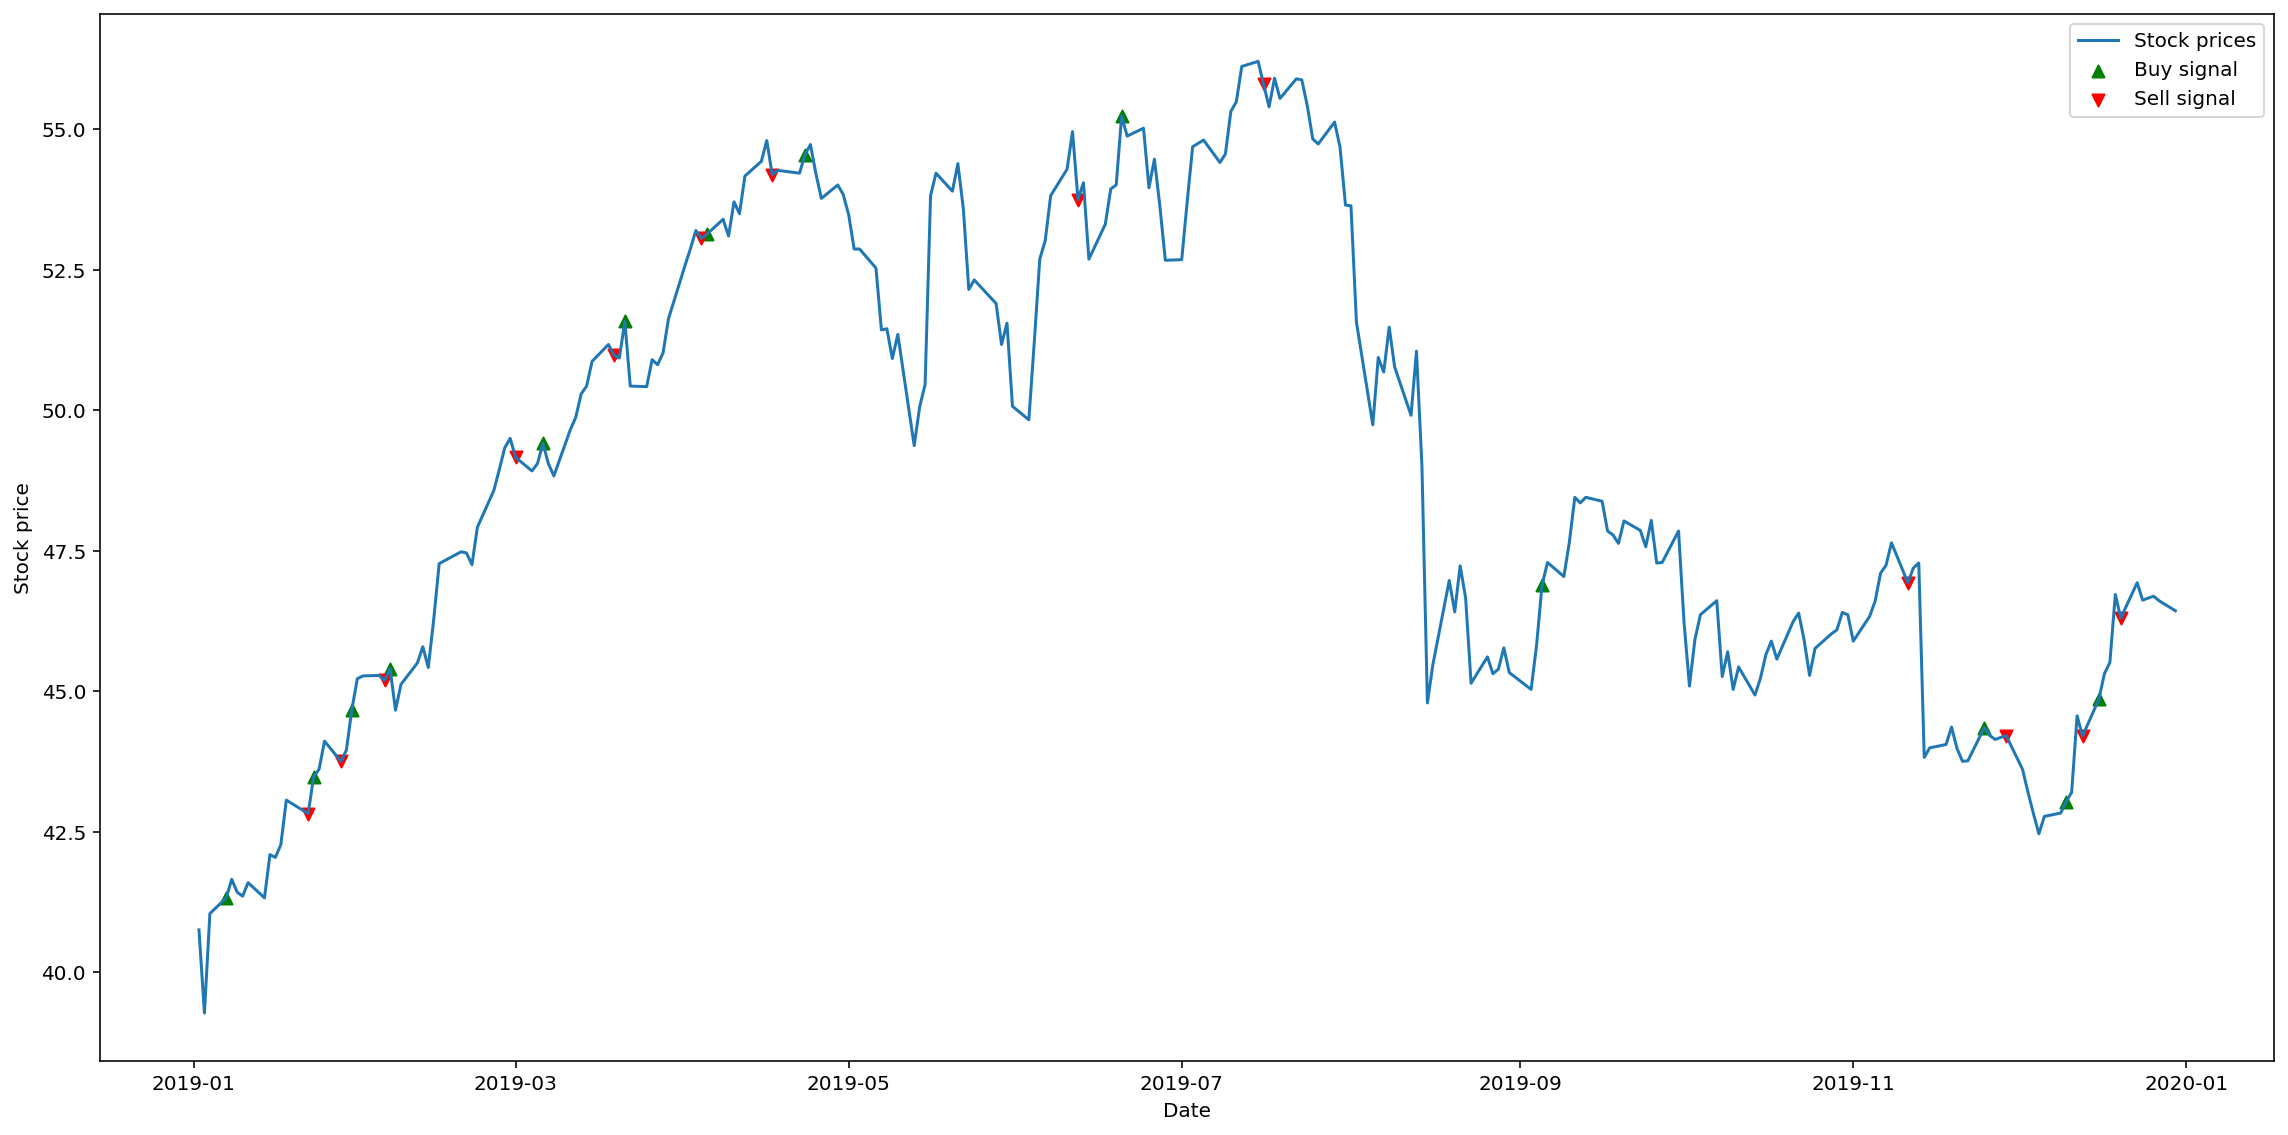

In [33]:
plot_strategy(evaluator, ticker_name='CSCO', start='2019-01-01', end='2019-12-31')

## DowDuPont

In [34]:
%%time
best_individual = find_best_strategy(ticker_name='DD', start='2016-01-01', end='2018-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 10 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-74.4476	25.2777	-17.3998	14.5641
1  	731   	-71.9984	28.6954	-8.75828	11.6008
Net profit of buy and hold: 12.261875000000003
Running backtesting ...
Best individual: [0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0]
Best average net profit: -0.2036308251435238
--------------------
Iteration 2 of 10 with best cv score: -0.2036308251435238
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-74.4476	25.2777	-17.3998	14.5641
1  	731   	-71.9984	28.6954	-8.75828	11.6008
2  	693   	-73.4446	28.6954	-2.11058	11.0829
Net prof

10 	732   	-75.5658	45.0918	20.7176 	16.2151
Net profit of buy and hold: 12.261875000000003
Running backtesting ...
Best individual: [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1]
Best average net profit: 8.578081961012712
--------------------
Iteration 11 of 10 with best cv score: 8.578081961012712
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-74.4476	25.2777	-17.3998	14.5641
1  	731   	-71.9984	28.6954	-8.75828	11.6008
2  	693   	-73.4446	28.6954	-2.11058	11.0829
3  	732   	-71.8792	28.6954	2.90854 	10.0403
4  	728   	-73.7501	30.9357	7.63493 	9.76254
5  	736   	-72.7027	31.7069	10.1381 	10.5647
6  	732   	-72.7027	34.6504	12.3223 	12.1433
7  	768   	-72.7027	41.1156	14.7834 	12.1551
8  	718   	-72.7027	44

5  	736   	-72.7027	31.7069	10.1381 	10.5647
6  	732   	-72.7027	34.6504	12.3223 	12.1433
7  	768   	-72.7027	41.1156	14.7834 	12.1551
8  	718   	-72.7027	44.309 	17.0772 	11.5354
9  	701   	-73.6125	44.309 	19.2213 	13.4967
10 	732   	-75.5658	45.0918	20.7176 	16.2151
11 	724   	-78.0979	44.309 	23.6336 	15.3188
12 	702   	-76.2173	44.309 	26.5667 	16.5104
13 	697   	-76.2173	48.0954	30.3366 	15.3413
14 	728   	-74.7676	46.1307	32.9746 	15.2902
15 	722   	-72.833 	47.7186	32.9904 	18.2494
16 	691   	-73.7775	48.0704	35.9923 	14.1634
17 	734   	-72.7027	48.0954	35.53   	17.2725
Net profit of buy and hold: 12.261875000000003
Running backtesting ...
Best individual: [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0]
Best average net profit: 8.78558307250

In [35]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DD', start='2019-01-01', end='2019-12-31')
results['DD'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[4, 44, 91], [29, 4]]
Net profit of strategy: -4.861000
Net profit of buy and hold: -13.107875
Percentage profit of strategy: -6.572472%
Percentage profit of buy and hold: -17.722925%
Number of buy signals: 2
Number of sell signals: 2


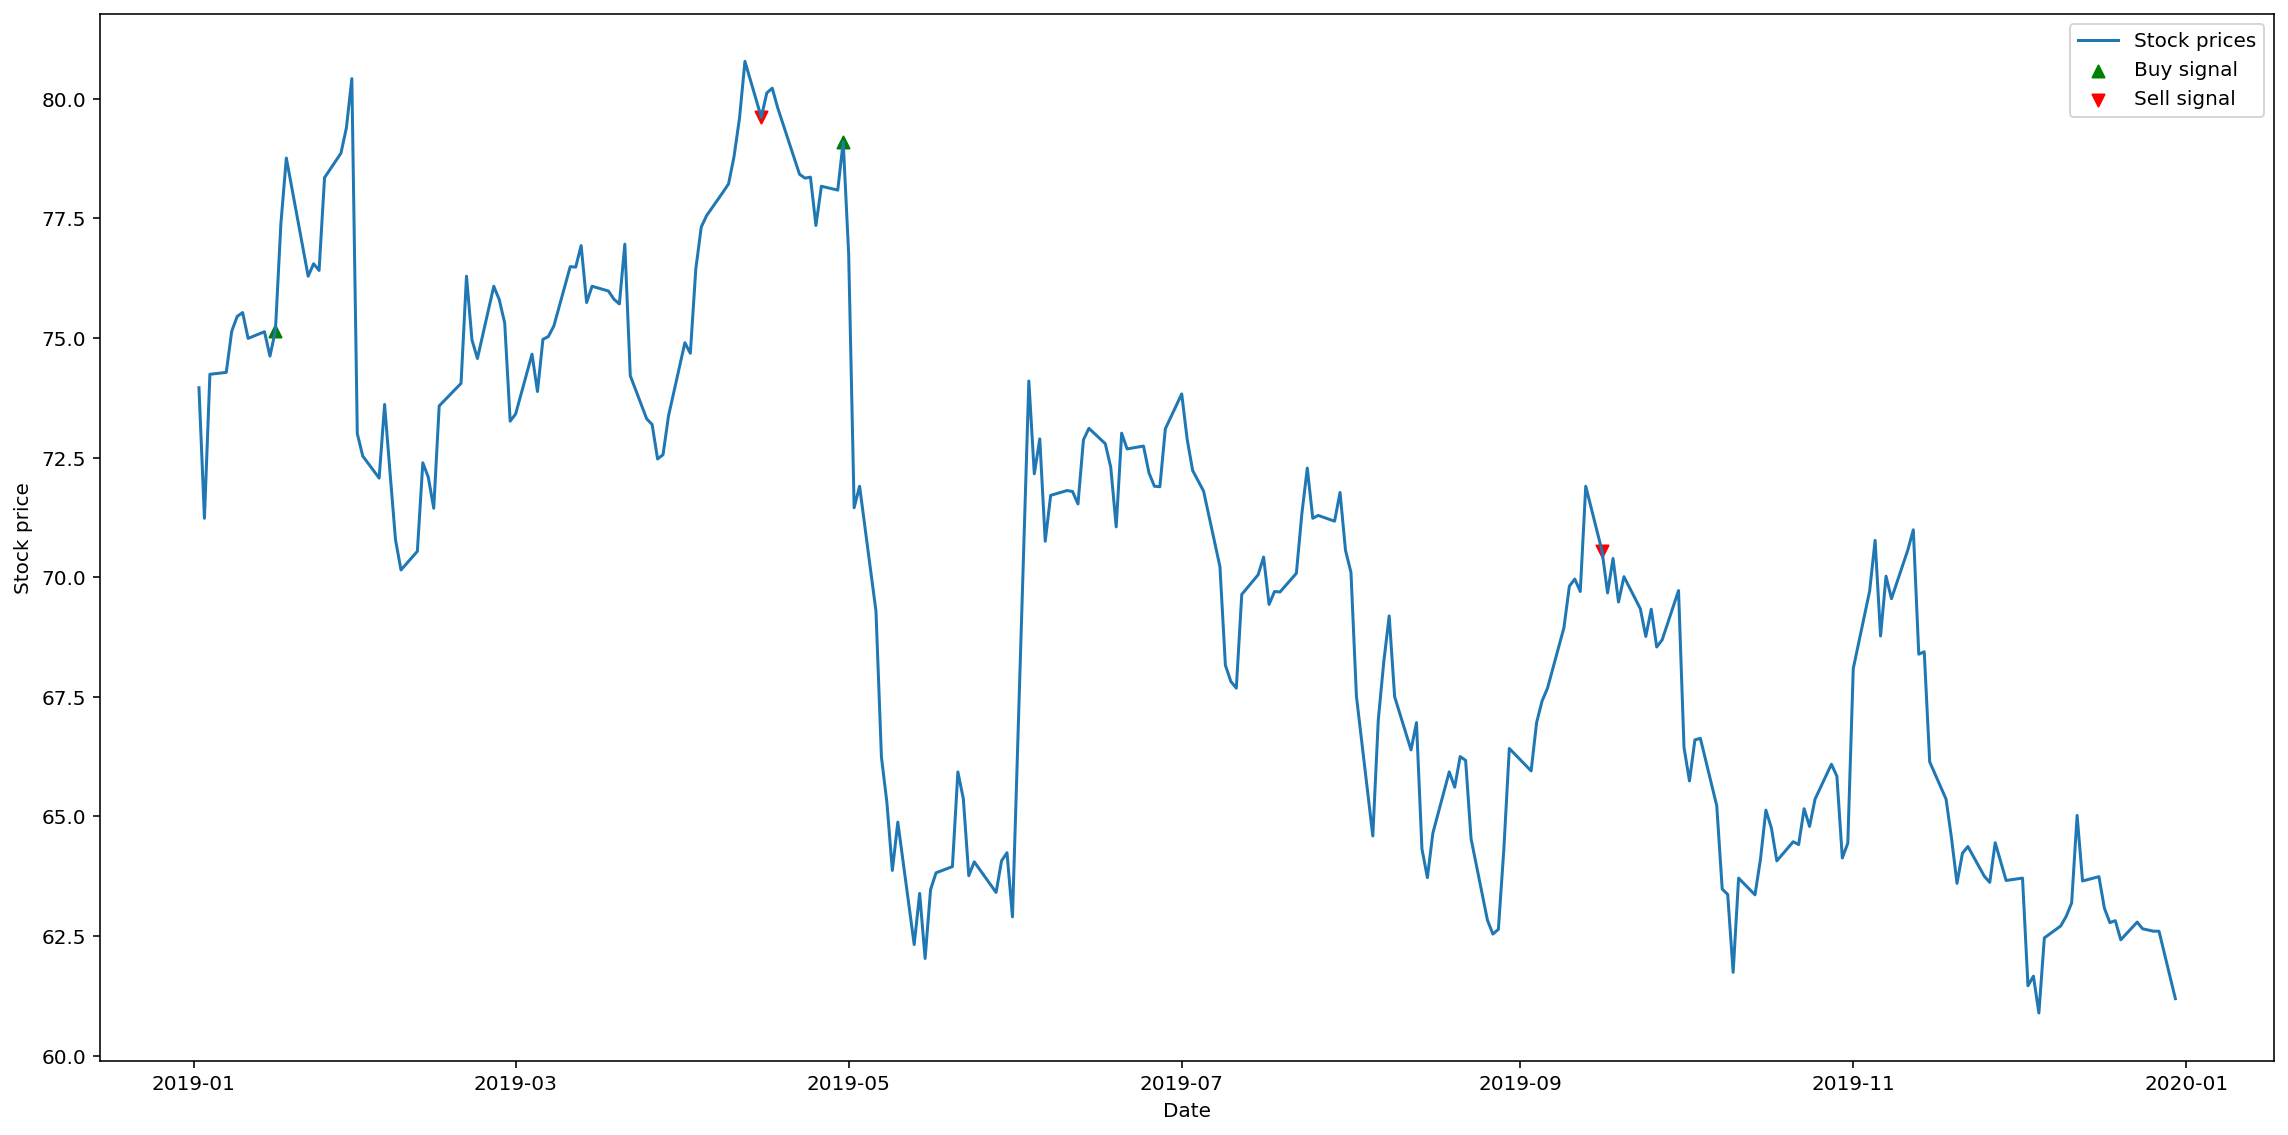

In [36]:
plot_strategy(evaluator, ticker_name='DD', start='2019-01-01', end='2019-12-31')

## JPMorgan Chase

In [37]:
%%time
best_individual = find_best_strategy(ticker_name='JPM', start='2016-01-01', end='2018-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 10 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std    
0  	1000  	-74.7012	37.1167	-2.4189	15.5381
1  	731   	-34.9271	37.1167	7.61161	11.1005
Net profit of buy and hold: 35.241775
Running backtesting ...
Best individual: [1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0]
Best average net profit: 7.106530331290388
--------------------
Iteration 2 of 10 with best cv score: 7.106530331290388
Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std    
0  	1000  	-74.7012	37.1167	-2.4189	15.5381
1  	731   	-34.9271	37.1167	7.61161	11.1005
2  	693   	-85.9088	37.1167	13.1001	11.544 
Net profit of buy and hold: 

gen	nevals	min     	max    	mean   	std    
0  	1000  	-74.7012	37.1167	-2.4189	15.5381
1  	731   	-34.9271	37.1167	7.61161	11.1005
2  	693   	-85.9088	37.1167	13.1001	11.544 
3  	732   	-71.2428	37.1167	17.6021	12.0135
4  	728   	-71.2428	47.9687	21.1749	12.3887
5  	736   	-71.2428	47.9687	24.1325	12.5487
6  	732   	-71.2846	54.2107	26.5203	13.5914
7  	768   	-69.7673	54.6596	29.2844	13.3777
8  	718   	-70.1652	54.6596	32.482 	13.0998
9  	701   	-70.0539	56.911 	35.9049	12.2941
10 	732   	-70.1652	56.911 	36.4851	13.9199
11 	724   	-24.7108	56.911 	38.7283	12.3291
Net profit of buy and hold: 35.241775
Running backtesting ...
Best individual: [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0]
Best average net profit: 17.49845230654761
-----------------

gen	nevals	min     	max    	mean   	std    
0  	1000  	-74.7012	37.1167	-2.4189	15.5381
1  	731   	-34.9271	37.1167	7.61161	11.1005
2  	693   	-85.9088	37.1167	13.1001	11.544 
3  	732   	-71.2428	37.1167	17.6021	12.0135
4  	728   	-71.2428	47.9687	21.1749	12.3887
5  	736   	-71.2428	47.9687	24.1325	12.5487
6  	732   	-71.2846	54.2107	26.5203	13.5914
7  	768   	-69.7673	54.6596	29.2844	13.3777
8  	718   	-70.1652	54.6596	32.482 	13.0998
9  	701   	-70.0539	56.911 	35.9049	12.2941
10 	732   	-70.1652	56.911 	36.4851	13.9199
11 	724   	-24.7108	56.911 	38.7283	12.3291
12 	702   	-70.1652	56.911 	40.0351	14.4044
13 	697   	-70.1652	61.5468	41.0336	14.3183
14 	728   	-70.1652	60.2335	42.8199	13.6478
15 	722   	-71.2428	60.2335	44.5507	13.7518
16 	691   	-13.0626	61.2081	47.2203	12.3724
17 	734   	-4.24167	61.8676	48.5402	12.3465
18 	685   	-24.8902	62.153 	49.1992	12.9343
Net profit of buy and hold: 35.241775
Running backtesting ...
Best individual: [0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0

In [38]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='JPM', start='2019-01-01', end='2019-12-31')
results['JPM'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[4, 63, 91], [28, 6]]
Net profit of strategy: 20.541425
Net profit of buy and hold: 40.648000
Percentage profit of strategy: 21.901509%
Percentage profit of buy and hold: 43.339375%
Number of buy signals: 4
Number of sell signals: 4


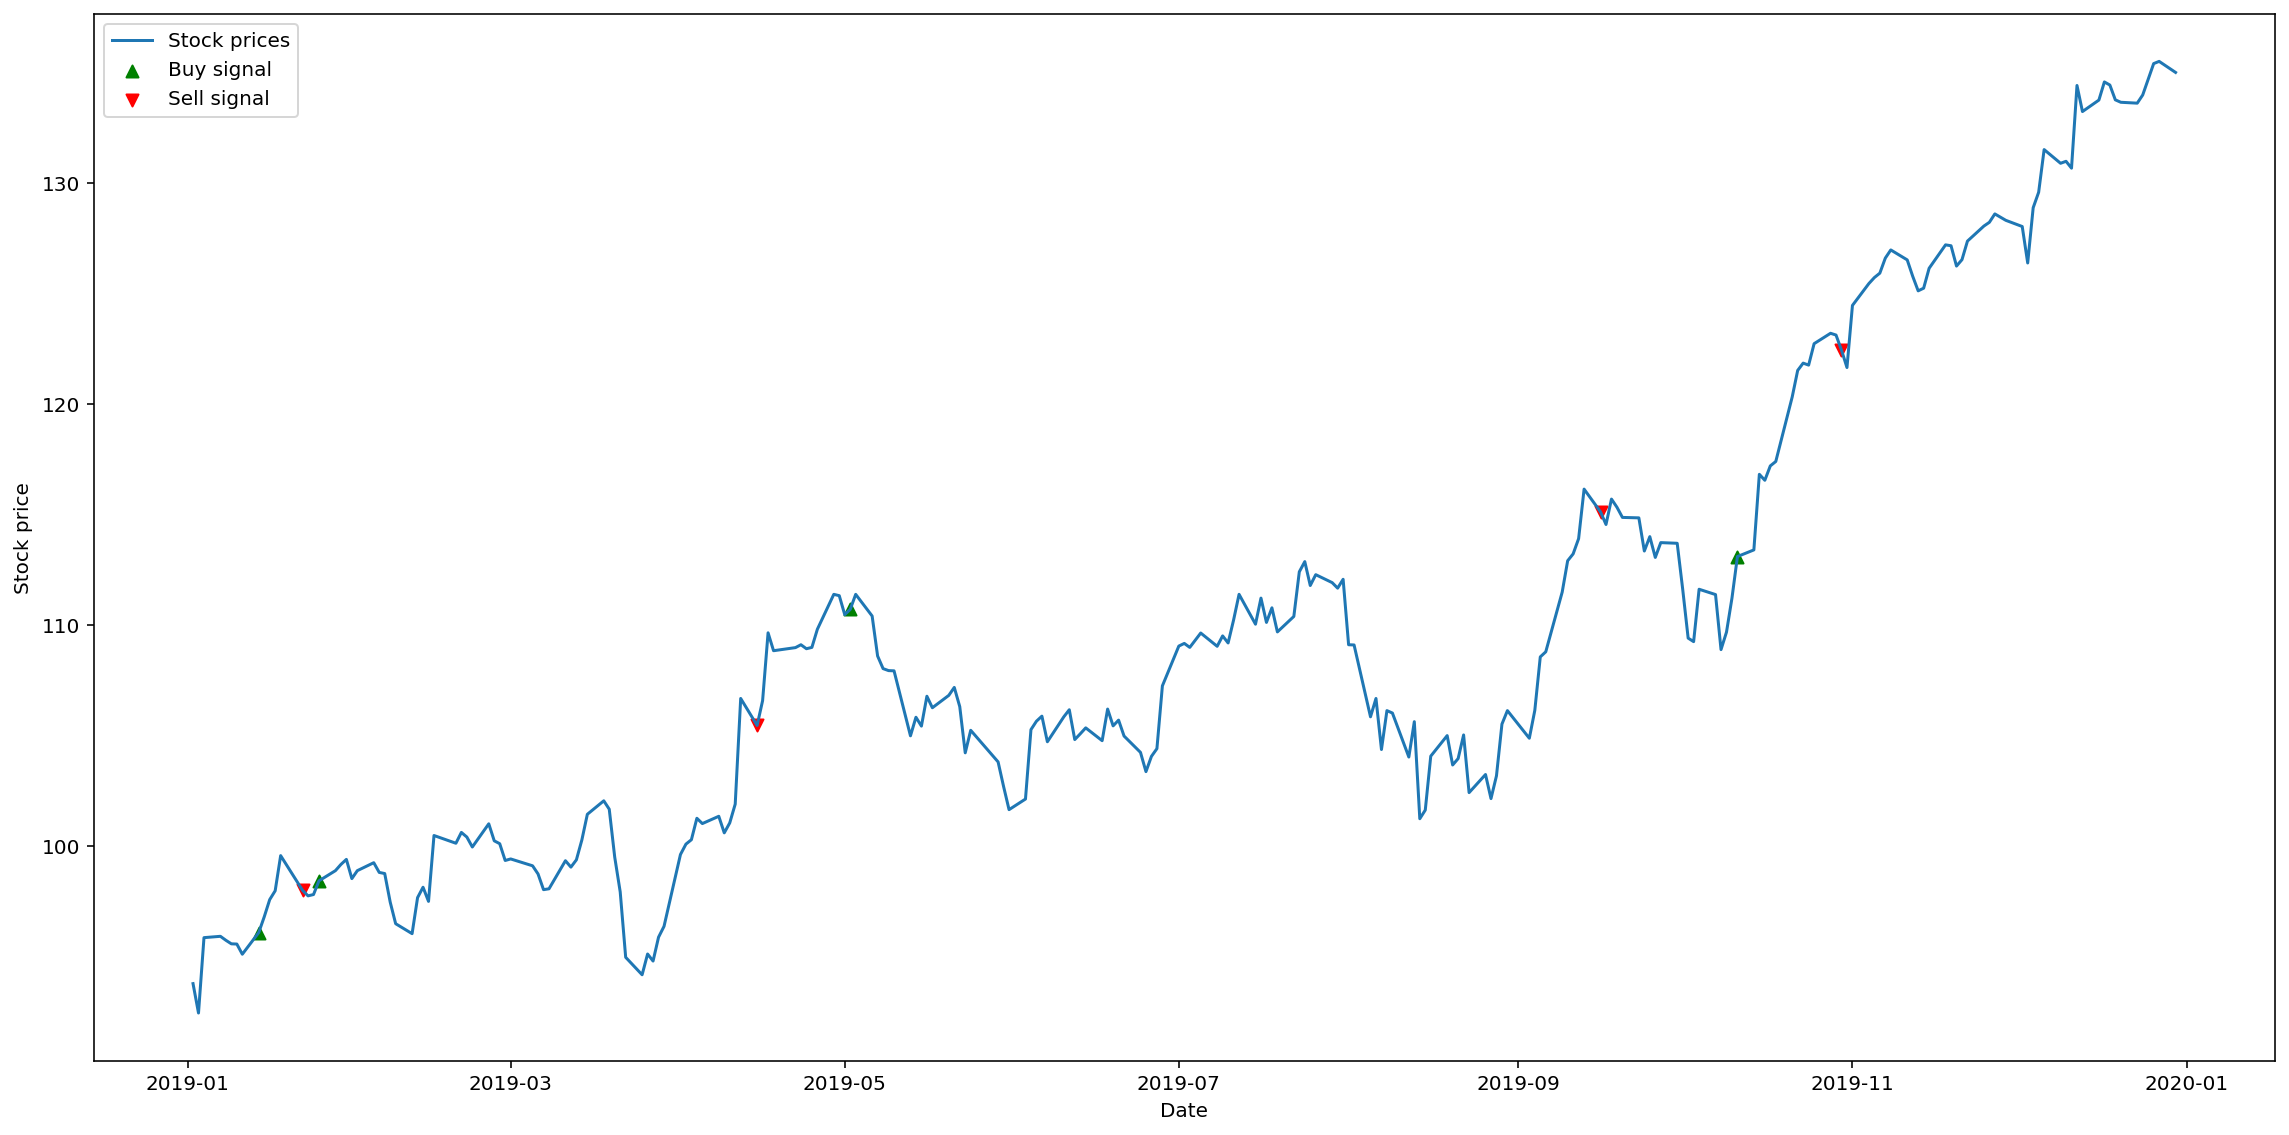

In [39]:
plot_strategy(evaluator, ticker_name='JPM', start='2019-01-01', end='2019-12-31')

## Microsoft

In [40]:
%%time
best_individual = find_best_strategy(ticker_name='MSFT', start='2016-01-01', end='2018-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 10 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-90.2665	44.3764	-13.9853	18.9319
1  	731   	-85.4313	49.0269	-2.02513	17.7733
Net profit of buy and hold: 47.639275000000005
Running backtesting ...
Best individual: [0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1]
Best average net profit: 7.111820547789713
--------------------
Iteration 2 of 10 with best cv score: 7.111820547789713
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-90.2665	44.3764	-13.9853	18.9319
1  	731   	-85.4313	49.0269	-2.02513	17.7733
2  	693   	-87.4818	49.0269	9.21054 	19.1424
Net profit o

10 	732   	-85.5756	54.7691	42.8856 	18.3427
Net profit of buy and hold: 47.639275000000005
Running backtesting ...
Best individual: [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]
Best average net profit: 3.484955940389544
--------------------
Iteration 11 of 10 with best cv score: 7.111820547789713
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-90.2665	44.3764	-13.9853	18.9319
1  	731   	-85.4313	49.0269	-2.02513	17.7733
2  	693   	-87.4818	49.0269	9.21054 	19.1424
3  	732   	-87.2022	50.6997	19.7663 	20.5208
4  	728   	-84.9165	50.6997	29.8714 	18.1563
5  	736   	-38.5937	51.7322	35.0353 	16.8602
6  	732   	-82.5612	54.4303	35.7068 	19.3098
7  	768   	-43.7544	54.4303	37.1464 	19.0636
8  	718   	-84.9165	54

5  	736   	-38.5937	51.7322	35.0353 	16.8602
6  	732   	-82.5612	54.4303	35.7068 	19.3098
7  	768   	-43.7544	54.4303	37.1464 	19.0636
8  	718   	-84.9165	54.7691	41.1466 	16.5524
9  	701   	-86.0626	54.7691	43.0218 	16.8334
10 	732   	-85.5756	54.7691	42.8856 	18.3427
11 	724   	-29.7136	54.7691	45.6893 	15.5425
12 	702   	-83.7469	54.7691	46.8934 	16.9671
13 	697   	-84.2602	55.483 	47.55   	17.3166
14 	728   	-43.8292	55.483 	48.9593 	16.4081
15 	722   	-35.1452	55.483 	47.71   	18.1812
16 	691   	-47.5132	54.7691	48.9227 	17.2696
17 	734   	-31.3705	54.7691	49.3073 	16.5417
Net profit of buy and hold: 47.639275000000005
Running backtesting ...
Best individual: [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]
Best average net profit: -0.5602441614

In [41]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='MSFT', start='2019-01-01', end='2019-12-31')
results['MSFT'].append([percentage_profit, percentage_profit_bh])

Active rules: ['ExponentialMovingAverage', 'RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[111], [36, 56, 108], [214], [52, 4]]
Net profit of strategy: 14.733575
Net profit of buy and hold: 56.851975
Percentage profit of strategy: 14.903475%
Percentage profit of buy and hold: 57.507561%
Number of buy signals: 1
Number of sell signals: 1


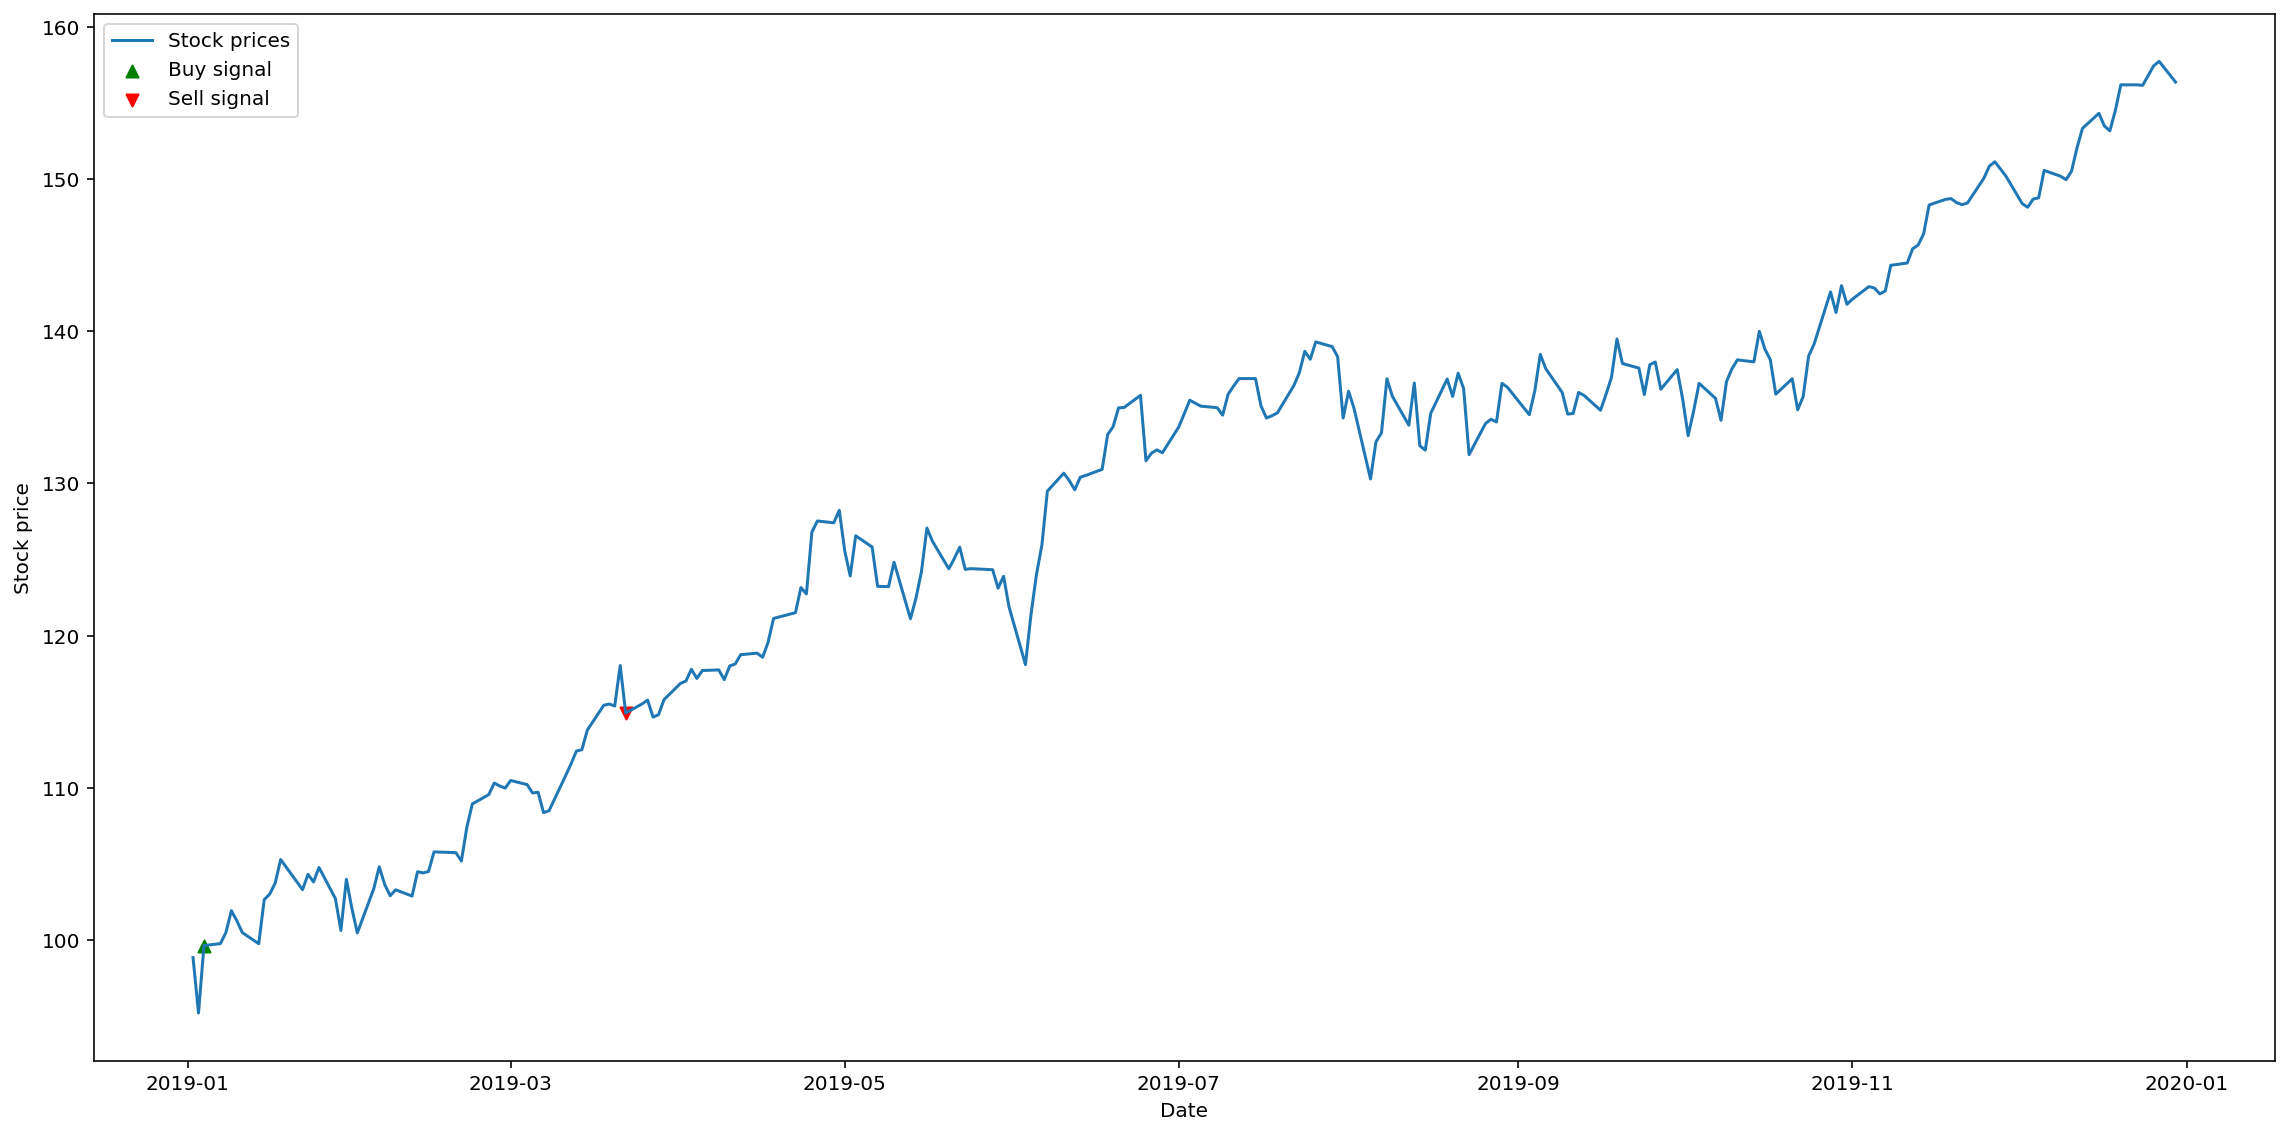

In [42]:
plot_strategy(evaluator, ticker_name='MSFT', start='2019-01-01', end='2019-12-31')

## Nike

In [43]:
%%time
best_individual = find_best_strategy(ticker_name='NKE', start='2016-01-01', end='2018-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 10 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-77.8786	20.4213	-15.7115	13.7108
1  	731   	-71.3157	20.4213	-6.69454	10.261 
Net profit of buy and hold: 13.604675
Running backtesting ...
Best individual: [1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
Best average net profit: 0.9596924217732397
--------------------
Iteration 2 of 10 with best cv score: 0.9596924217732397
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-77.8786	20.4213	-15.7115	13.7108
1  	731   	-71.3157	20.4213	-6.69454	10.261 
2  	693   	-75.0377	29.2698	-0.96704	10.1276
Net profit of buy a

Best individual: [0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Best average net profit: 0.49123084960321217
--------------------
Iteration 11 of 10 with best cv score: 1.8097794719227067
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-77.8786	20.4213	-15.7115	13.7108
1  	731   	-71.3157	20.4213	-6.69454	10.261 
2  	693   	-75.0377	29.2698	-0.96704	10.1276
3  	732   	-72.6723	31.4896	2.60763 	10.2653
4  	728   	-44.557 	31.4896	6.82478 	9.66486
5  	736   	-75.2574	33.8933	8.65344 	11.1483
6  	732   	-73.1451	34.0701	10.7492 	11.8584
7  	768   	-47.9721	34.0701	13.5114 	11.8751
8  	718   	-39.0605	35.753 	17.4606 	11.2883
9  	701   	-28.1946	35.753 	21.152  	11.121 
10 	732   	-30.2076	35.753 	23.484  	12.0592


9  	701   	-28.1946	35.753 	21.152  	11.121 
10 	732   	-30.2076	35.753 	23.484  	12.0592
11 	724   	-47.4315	37.1743	26.772  	11.2958
12 	702   	-42.2535	38.04  	27.74   	11.3616
13 	697   	-39.4359	39.3476	28.7014 	10.9121
14 	728   	-41.6466	40.3637	28.758  	12.1064
15 	722   	-39.3882	42.5686	29.0903 	11.2653
16 	691   	-26.2103	42.5686	29.8436 	11.0251
17 	734   	-42.8432	42.6152	30.1031 	11.1873
Net profit of buy and hold: 13.604675
Running backtesting ...
Best individual: [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
Best average net profit: -0.09346751448552128
--------------------
Iteration 18 of 10 with best cv score: 1.8097794719227067
Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-77.8786	20.4213

In [44]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='NKE', start='2019-01-01', end='2019-12-31')
results['NKE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[220, 230], [59, 60, 25], [241], [50, 5]]
Net profit of strategy: 0.000000
Net profit of buy and hold: 26.878025
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: 36.950818%
Number of buy signals: 0
Number of sell signals: 0


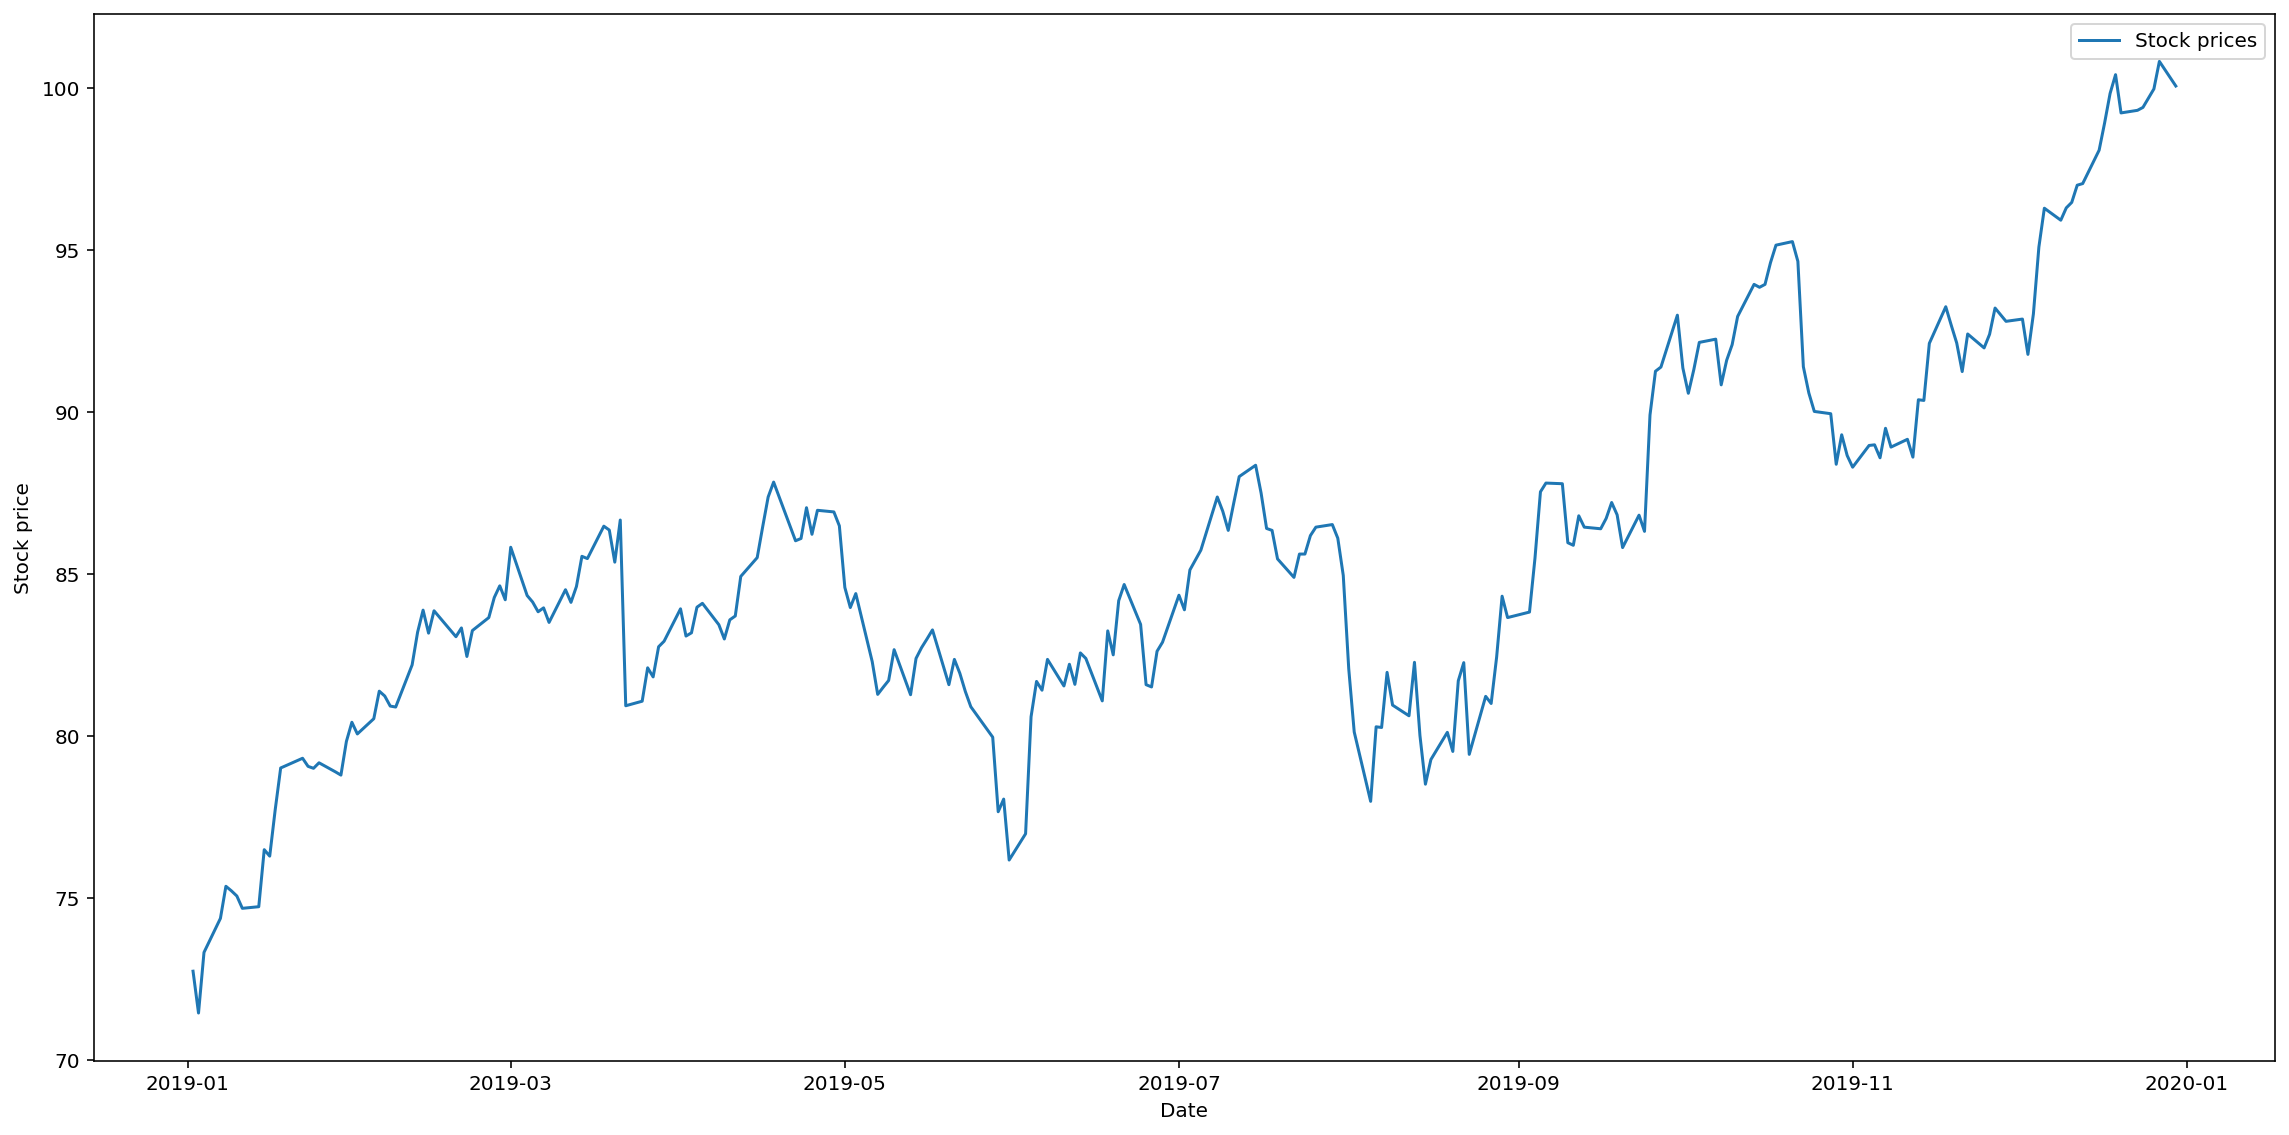

In [45]:
plot_strategy(evaluator, ticker_name='NKE', start='2019-01-01', end='2019-12-31')

## UnitedHealth

In [46]:
%%time
best_individual = find_best_strategy(ticker_name='UNH', start='2016-01-01', end='2018-12-31', ngen=None)

Trying to figure out optimal number of generations using grid search ...
Iteration 1 of 10 with best cv score: -inf
Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std    
0  	1000  	-100.878	133.353	1.38446	38.3464
1  	731   	-58.4832	133.353	25.746 	38.1755
Net profit of buy and hold: 130.18222500000002
Running backtesting ...
Best individual: [1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0]
Best average net profit: 27.863477467098992
--------------------
Iteration 2 of 10 with best cv score: 27.863477467098992
Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std    
0  	1000  	-100.878	133.353	1.38446	38.3464
1  	731   	-58.4832	133.353	25.746 	38.1755
2  	693   	-78.8268	133.353	47.4185	42.8753
Net profit of buy

Best individual: [1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1]
Best average net profit: 61.08166757956811
--------------------
Iteration 11 of 10 with best cv score: 61.08166757956811
Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std    
0  	1000  	-100.878	133.353	1.38446	38.3464
1  	731   	-58.4832	133.353	25.746 	38.1755
2  	693   	-78.8268	133.353	47.4185	42.8753
3  	732   	-75.4362	147.224	75.422 	45.2584
4  	728   	-76.264 	145.216	99.2549	40.7056
5  	736   	-73.4602	145.216	113.624	35.7123
6  	732   	-53.81  	162.884	116.393	37.5027
7  	768   	-46.7194	169.576	117.069	38.7033
8  	718   	-76.434 	169.576	120.007	38.2872
9  	701   	-73.4602	169.576	120.985	39.0655
10 	732   	-73.4602	174.717	121.975	41.8372
11 	724   	-73.

10 	732   	-73.4602	174.717	121.975	41.8372
11 	724   	-73.4602	169.928	127.482	38.7247
12 	702   	-73.4602	174.717	135.205	37.237 
13 	697   	-73.4602	174.717	140.36 	39.986 
14 	728   	-73.4602	174.717	144.802	39.2837
15 	722   	-73.4602	181.965	142.443	46.872 
16 	691   	-73.4602	181.965	147.943	39.5674
17 	734   	-73.4602	181.965	144.434	46.3281
Net profit of buy and hold: 130.18222500000002
Running backtesting ...
Best individual: [0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]
Best average net profit: 60.33900484277996
--------------------
Iteration 18 of 10 with best cv score: 61.08166757956811
Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std    
0  	1000  	-100.878	133.353	1.38446	38.3464
1  	731   	-58.4832	133.353	25.7

In [47]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='UNH', start='2019-01-01', end='2019-12-31')
results['UNH'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[4, 55, 91], [37, 5]]
Net profit of strategy: 47.467325
Net profit of buy and hold: 52.403650
Percentage profit of strategy: 20.078391%
Percentage profit of buy and hold: 22.166427%
Number of buy signals: 4
Number of sell signals: 4


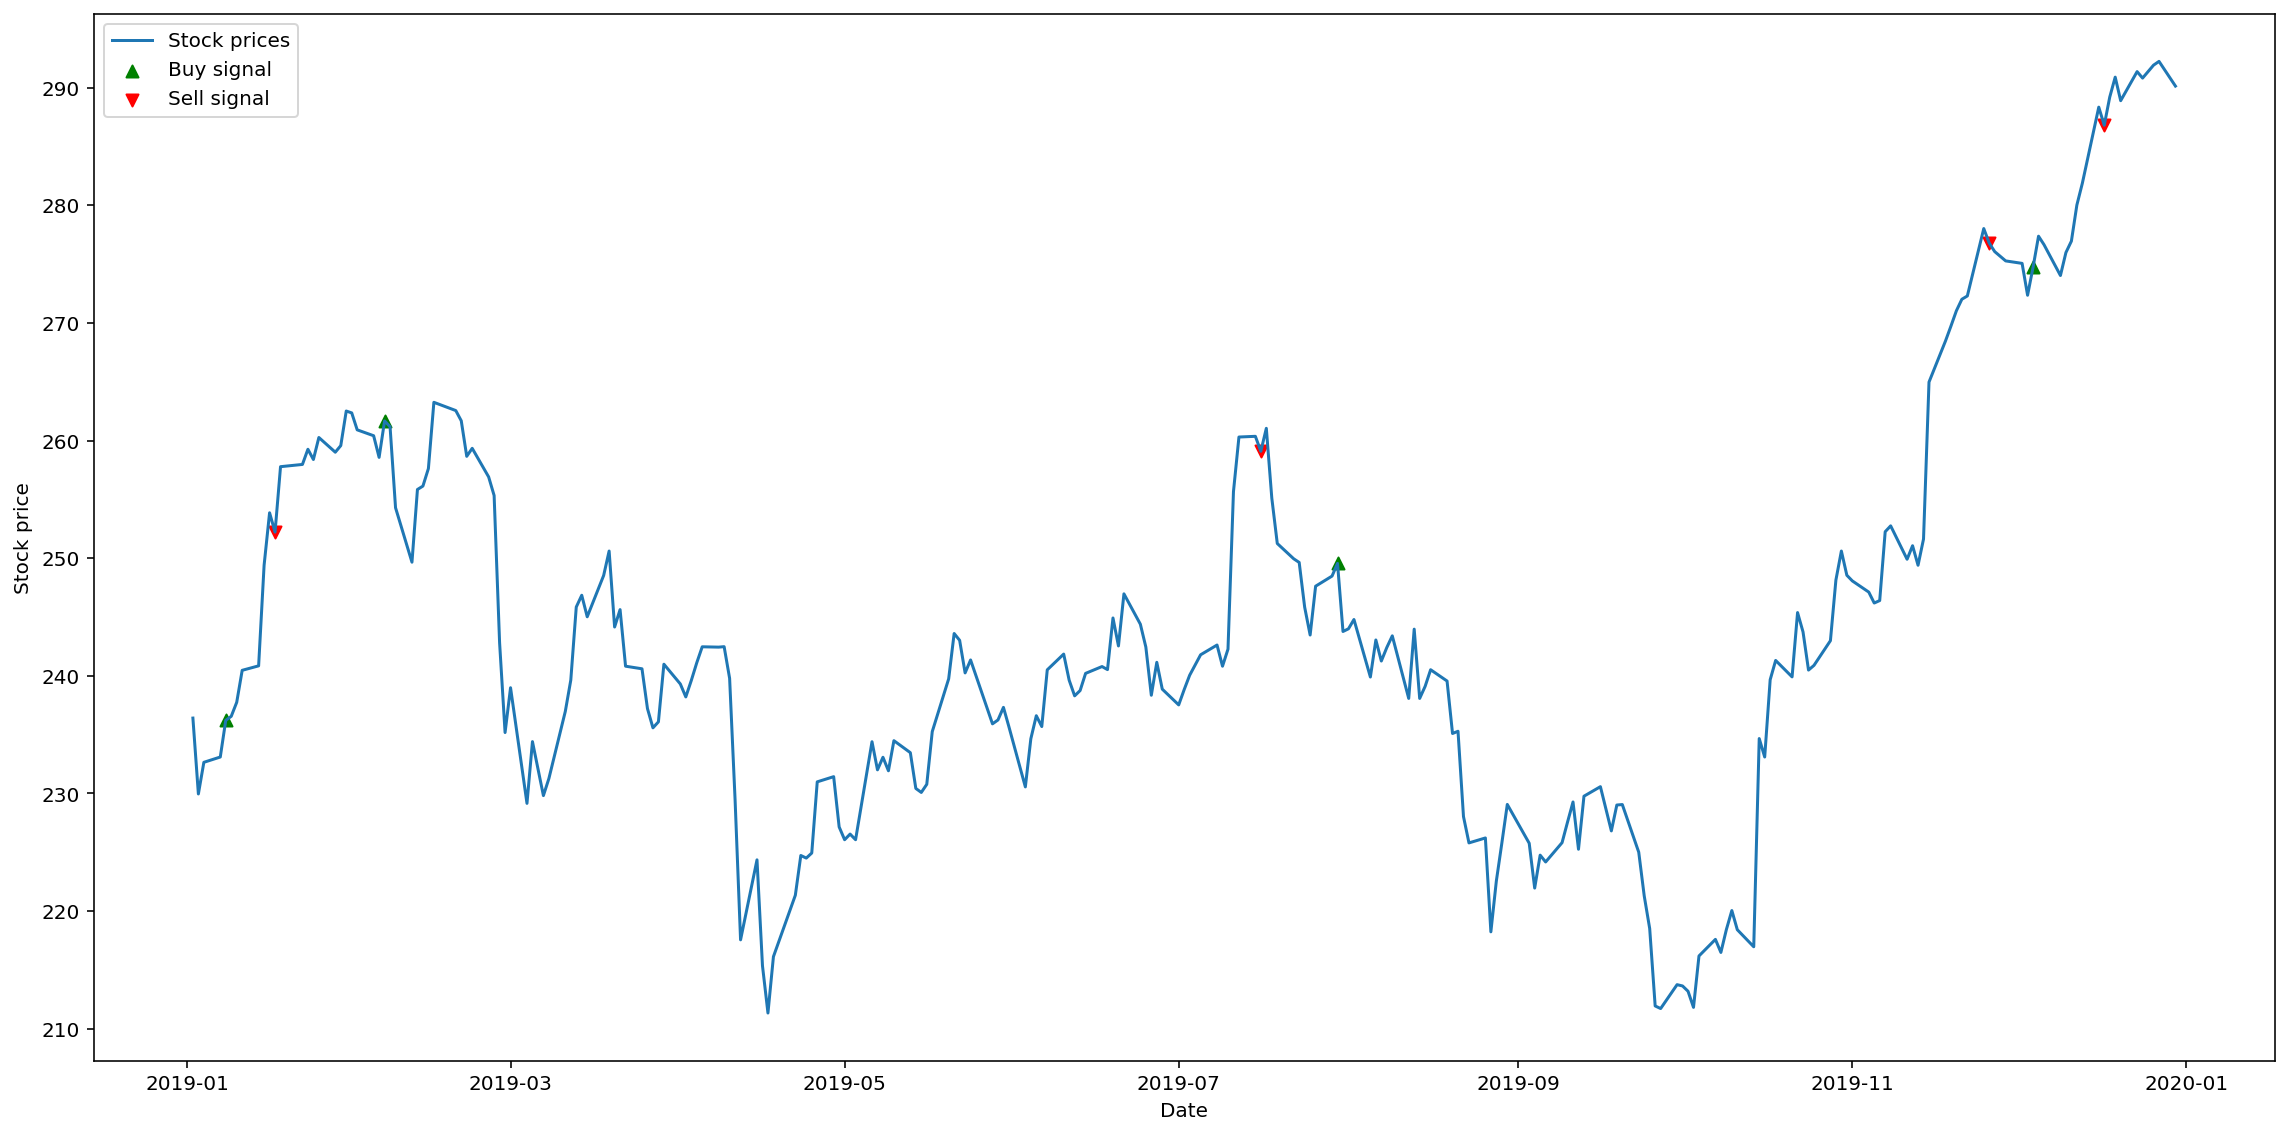

In [48]:
plot_strategy(evaluator, ticker_name='UNH', start='2019-01-01', end='2019-12-31')

# Results

In [49]:
results_df = pd.DataFrame(results)
results_df

,EXS1.DE,ADS.DE,ALV.DE,BAS.DE,DBK.DE,DTE.DE,SAP.DE,DJI,CSCO,DD,JPM,MSFT,NKE,UNH
0,"[11.46917507678815, 24.010750329091714]","[20.030181114724734, 58.64860659414599]","[19.984333333333332, 29.842999999999996]","[0.0, 15.491510365251738]","[-3.3129445234708412, -2.060810810810815]","[-0.7958591331269537, 2.4338235294117707]","[14.209038023269791, 39.54596977329974]","[0.0, 10.796113655545895]","[22.869693251533878, 13.403803680981593]","[-6.572471606273654, -17.72292455381287]","[21.901508689625754, 43.339375199914684]","[14.903474610560385, 57.507561197653246]","[0.0, 36.95081798185318]","[20.078391354003557, 22.166426970094328]"


In [50]:
ps_results = list()
bh_results = list()
for col in results_df.columns:
    results_df[col].apply(lambda result: ps_results.append(result[0]))
    results_df[col].apply(lambda result: bh_results.append(result[1]))

In [51]:
np.mean(ps_results)

9.626037156497725

In [52]:
np.mean(bh_results)

23.882430279472867